In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# LSTM - Dundee

This notebook goes through the process of training LSTM for Dundee. This time the dataset contains roughly 9 months of data which forced various compromises and influenced the modelling possibilities significantly. The model is trained to predict single next observation based on the previous records. The predictions are made on daily, weekly and monthly level to reflect companies needs for both short-term and long-term planning. Models are trained on each of the stations separately to achieve better performance.

### Data processing

Data comes in 3 different files which are merged together here. Some of the stations are renamed to avoid duplicates. Other are dropped due to unsufficent number of records.

In [13]:
# Pick only relevant columns for the analysis
columns_needed = ['Site', 'Charging event', 'Date', 'Total kWh']

# Load datasets and merge into one
df_1 = pd.read_csv('charge-sessions-june-sept.csv').drop(columns=['Unnamed: 13', 'Unnamed: 14'])
df_1['Date'] = pd.to_datetime(df_1['Start Date'], format="%d/%m/%Y")
df_1 = df_1[columns_needed]

df_2 = pd.read_csv('cp-data-dec-mar-2018.csv')
df_2['Date'] = pd.to_datetime(df_2['Start Date'], format="%d/%m/%Y")
df_2 = df_2[columns_needed]

df_3 = pd.read_csv('cp-data-mar-may-2018.csv')
df_3['Date'] = pd.to_datetime(df_3['Start Date'], format="%d/%m/%Y")
df_3 = df_3[columns_needed]

# Union data
df = pd.concat([df_1, df_2, df_3]).drop_duplicates()
df = df[df['Site'] != '***TEST SITE*** Charge Your Car HQ']
df = df[df['Site'] != 'Dundee House, Dundee']
df = df[df['Site'] != 'Princes Street Charging Hub']

# Define a mapping dictionary for renaming
rename_mapping = {
    'Sinclair Street, Dundee': 'Sinclair Street',
    'South Tay Street, Dundee': 'South Tay Street',
    'Trades Lane, Dundee': 'Trades Lane',
}

df['Site'] = df['Site'].replace(rename_mapping)
df.head()

Site  Charging event       Date  \
0                    Lochee Charging Hub, Dundee         7751157 2018-09-06   
1             Greenmarket Multi Car Park, Dundee         7751142 2018-09-06   
2  Queen Street Car Park, Broughty Ferry, Dundee         7751140 2018-09-06   
3                    Housing Office West, Dundee         7751138 2018-09-06   
4                    Housing Office West, Dundee         7751136 2018-09-06   

   Total kWh  
0     22.287  
1      7.080  
2      8.220  
3      4.780  
4      7.080

In [14]:
# Construct dictionary for storing the datasets
stations = df['Site'].unique()
stations_dict = {}

for station in stations:
    stations_dict[station] = {'data':pd.DataFrame(), 'daily':pd.DataFrame(), 'weekly':pd.DataFrame(), 'monthly':pd.DataFrame()}
    stations_dict[station]['data'] = df[df['Site'] == station]

In [15]:
print('STATION NAMES: \n')

for station in stations:
    print(station)
    df_temp = stations_dict[station]['data'].copy()
    
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp['Year-Month'] = df_temp['Date'].dt.strftime('%Y-%m')

    # Define the start date and end date
    start_date = df_temp['Date'].min()
    end_date = df_temp['Date'].max()

    # Calculate the number of weeks from the start date for each date
    df_temp['Week_index'] = (df_temp['Date'] - start_date).dt.days // 7

    stations_dict[station]['data'] = df_temp

STATION NAMES: 

Lochee Charging Hub, Dundee
Greenmarket Multi Car Park, Dundee
Queen Street Car Park, Broughty Ferry, Dundee
Housing Office West, Dundee
Nethergate, Dundee
Brington Place Sheltered Housing, Dundee
Balunie Drive, Dundee
Social Work Building, Jack Martin Way, Dundee
Dundee Ice Arena, Dundee
Mitchell Street, Dundee
Oakland Day Centre, Dundee
Dock Street, Dundee
Whitfield Centre, Dundee
Housing Office East, Dundee
Gellatly Street Car Park, Dundee
Public Works Dept, Clepington Rd. Dundee
Marchbanks, Dundee
Olympia Multi-Storey Car Park, Dundee
South Tay Street
Ardler Complex, Dundee
Menziehill House, Dundee
Turriff House Rannoch Road, Dundee
Trades Lane
University of Dundee, Nethergate, Dundee
Janet Brougham House, Dundee
DCC Environment, 34 Harefield Road
Sinclair Street
Earn Cresent, Dundee


There are 28 stations in Dundee dataset. This is much more than in case of other two cities.

Each timeframe model (daily, weekly, monthly) requires appropriately grouped data. The following sections process the data so that each of the records represents one observation (e.g. summed energy demand from all chargings for a day). Unlike in case of Palo Alto, just like in Perth, dataset contains quiety significant number of missing observations. This data quality problem is caused by technical reasons therefore it has been decided that those values should be filled with rolling average of 5 previous observations (or mean for the whole dataset for the first five observations). This issue will certainly impact the predictions.

### Daily data processing

In [17]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    daily = df_temp.groupby(['Date', 'Site'])['Total kWh'].sum().reset_index()

    # Define the complete date range
    start_date = df_temp['Date'].min()
    end_date = df_temp['Date'].max()
    date_range = pd.date_range(start=start_date, end=end_date)

    station_data = pd.DataFrame({'Date': date_range, 'Site': station})

    # Merge the complete data with the daily DataFrame to fill in missing values with 0
    daily_merged = pd.merge(station_data, daily, on=['Date', 'Site'], how='left')

    # Use mean for filling missing data 
    mean_energy = daily_merged['Total kWh'].mean()
    rolling_mean_energy = daily_merged['Total kWh'].rolling(window=5).mean().shift(1).fillna(mean_energy)
    daily_merged['Total kWh'] = daily_merged['Total kWh'].fillna(rolling_mean_energy)

    stations_dict[station]['daily'] = daily_merged

### Weekly data processing

In [18]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    
    # Group by Week_index and Station Name to get weekly energy consumption
    weekly = df_temp.groupby(['Week_index', 'Site'])['Total kWh'].sum().reset_index()

    # Define the complete week index range
    start_week = df_temp['Week_index'].min()
    end_week = df_temp['Week_index'].max()
    week_range = range(start_week, end_week + 1)

    station_data = pd.DataFrame({'Week_index': week_range, 'Site': station})

    # Merge the complete data with the weekly DataFrame to fill in missing values with 0
    weekly_merged = pd.merge(station_data, weekly, on=['Week_index', 'Site'], how='left')

    # Use mean for filling missing data 
    mean_energy = weekly_merged['Total kWh'].mean()
    rolling_mean_energy = weekly_merged['Total kWh'].rolling(window=5).mean().shift(1).fillna(mean_energy)
    weekly_merged['Total kWh'] = weekly_merged['Total kWh'].fillna(rolling_mean_energy)

    stations_dict[station]['weekly'] = weekly_merged

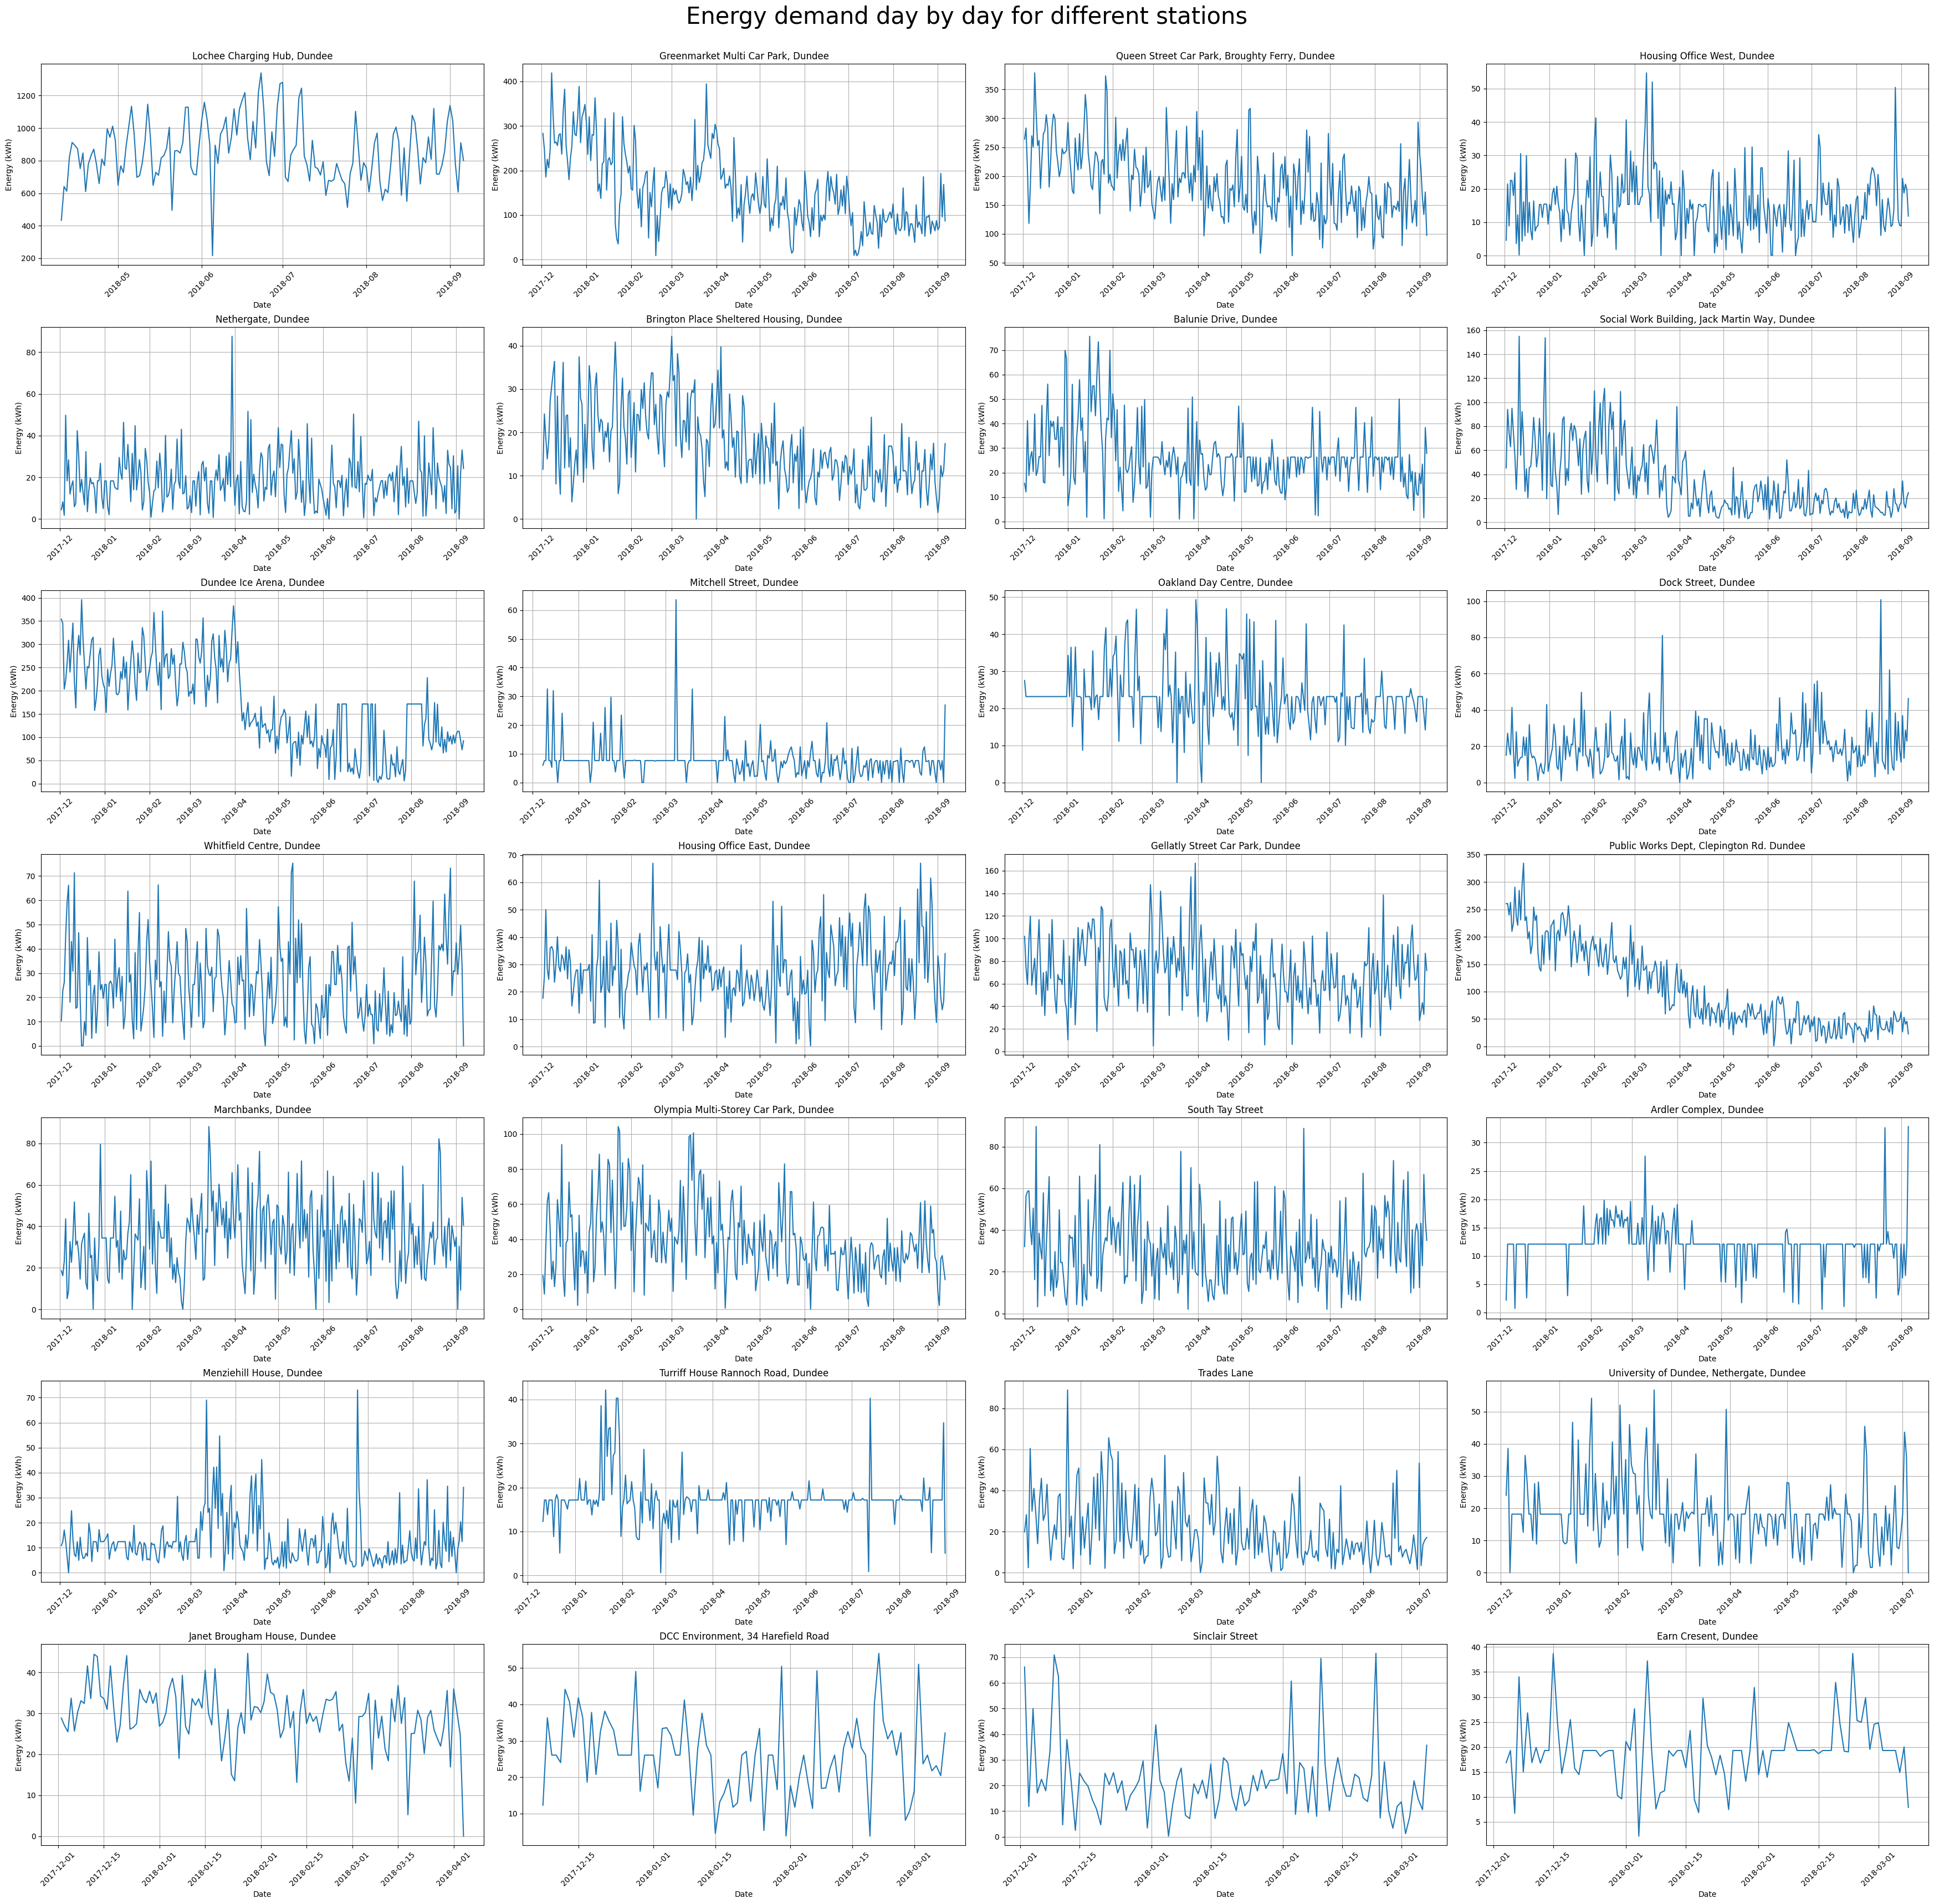

In [21]:
# Define the number of rows and columns for the subplots
num_rows = 7
num_cols = 4

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(35, 35))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Iterate over each station and plot on a separate subplot
for i, station in enumerate(stations):
    plot_df = stations_dict[station]['daily']
    ax = axs[i]
    ax.plot(plot_df['Date'], plot_df['Total kWh'])
    ax.set_title(station)
    ax.set_xlabel('Date')
    ax.set_ylabel('Energy (kWh)')
    ax.grid(True)
    plt.setp(ax.get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Energy demand day by day for different stations', fontsize=30)
plt.show()

Just like for other cities the variance in demand is rather high. The series look almost like whitenoise without clear cycle patterns which manifests to difficulty of forming a decent predictions. The problem with missing values touches only some of the stations and its magnitude is smaller than in case of Perth. The challenge in case of Dundee is most certainly lack of sufficiently long timeframe.

### Model definition

The network will contain an lstm layer and a linear layer on top of it. The model is further initiated in the train function with `input_size` = 1 as it aims at predicting the single next observation, `hidden_size` = 64 indicating number of neurons in the hidden layer, `num_layer` = 1 as only one lstm layer is used. Dropout of `0.5` is also implemented to help with the regularization by randomly deactivating portion of the neurons in the hidden layer.

In [22]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        # extract only the last time step
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


The following training loop performs the following operations: 
- scales the data to 0-1, 
- creates a sequence of chosen length reflecting the lookback period
- split data into train and test sets
- initiates model
- trains the model evaluating both train and test error
- saves necessary outputs

In [24]:
def train_lstm(df_dict, type, sequence_length, stations, num_epochs, predictions_dict, test_obs):
    for station in stations:
        print('\n', station, '\n')
        temp_df = df_dict[station][type]['Total kWh']

        # Scaling dataset
        reshaped_data = np.reshape(temp_df, (-1,1))
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(reshaped_data)

        # Create sequences and labels for training data
        sequence_length = sequence_length  # Number of time steps to look back
        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:i+sequence_length])
            y.append(scaled_data[i+sequence_length])
        X, y = np.array(X), np.array(y)

        # Splitting the dataset
        X_train = X[:-test_obs]
        y_train = y[:-test_obs]
        X_test = X[-test_obs:]
        y_test = y[-test_obs:]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
        # Convert data to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32)
        X_train.shape,y_train.shape

        input_size = 1
        num_layers = 1
        hidden_size = 64
        
        # Define the model, loss function, and optimizer
        model = LSTMModel(input_size, hidden_size, num_layers).to(device)
        
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        batch_size = 15
        # Create DataLoader for batch training
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
        # Create DataLoader for batch training
        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        num_epochs = num_epochs
        train_hist = []
        test_hist = []
        # Training loop
        for epoch in range(num_epochs):
            total_loss = 0.0

            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = loss_fn(predictions, batch_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Calculate average training loss and accuracy
            average_loss = total_loss / len(train_loader)
            train_hist.append(average_loss)

            # Validation on test data
            model.eval()
            with torch.no_grad():
                total_test_loss = 0.0

                for batch_X_test, batch_y_test in test_loader:
                    batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                    predictions_test = model(batch_X_test)
                    test_loss = loss_fn(predictions_test, batch_y_test)

                    total_test_loss += test_loss.item()

                # Calculate average test loss and accuracy
                average_test_loss = total_test_loss / len(test_loader)
                test_hist.append(average_test_loss)
            if (epoch+1)%10==0:
                print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

        #training plot
        x = np.linspace(1,num_epochs,num_epochs)
        plt.plot(x, train_hist, scalex=True, label="Training loss")
        plt.plot(x, test_hist, label="Test loss")
        plt.suptitle(station)
        plt.legend()
        plt.show()

        # # Save the model's state dictionary to a file
        # if station == 'HAMILTON':
        #     torch.save(model.state_dict(), f'lstm_model_weekly_{station}.pth')

        # # Save the model's state dictionary to a file
        # if station == 'MPL':
        #     torch.save(model.state_dict(), f'lstm_model_weekly_{station}.pth')
        
        # Set the model to evaluation mode
        model.eval()

        # Move input tensor to the same device as model's parameters
        X_test = X_test.to(device)

        # Pass the entire test set through the model to obtain predictions
        with torch.no_grad():
            # Obtain predictions for the entire test set
            predictions_test = model(X_test)
            
            # Convert predictions from tensors to NumPy arrays
            predictions_test = predictions_test.cpu().numpy()

        # Reverse predictions
        y_test_reversed = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_reversed = scaler.inverse_transform(predictions_test.reshape(-1, 1))

        # Save y_test and predictions
        predictions_dict[station]['y_pred'] = predictions_reversed
        predictions_dict[station]['y_test'] = y_test_reversed

        # Calculate mean squared error
        mse = mean_squared_error(y_test_reversed, predictions_reversed)

        # Calculate root mean squared error
        rmse = np.sqrt(mse)

        print(f"{station} Root Mean Squared Error (RMSE):", rmse)
        predictions_dict[station]['rmse'] = rmse

Training of each model has been evaluated for various combinations of hyperparameters. The following results present only the final chosen models.

### Daily LSTM training

Daily model is trained to predict based on 30 previous observations. Test set contains last 30 observations (rest is used for training). It is trained only for 50 epochs to avoid overfitting. The training output has been colapsed as it used only for diagnostics. Results are shown at the end.

In [26]:
# Initialize dict for storing predictions
daily_predictions_dict = {}
for station in stations:
    daily_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}


 Lochee Charging Hub, Dundee 

(90, 30, 1) (90, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0300, Test Loss: 0.0216
Epoch [20/50] - Training Loss: 0.0303, Test Loss: 0.0217
Epoch [30/50] - Training Loss: 0.0301, Test Loss: 0.0217
Epoch [40/50] - Training Loss: 0.0299, Test Loss: 0.0217
Epoch [50/50] - Training Loss: 0.0296, Test Loss: 0.0216


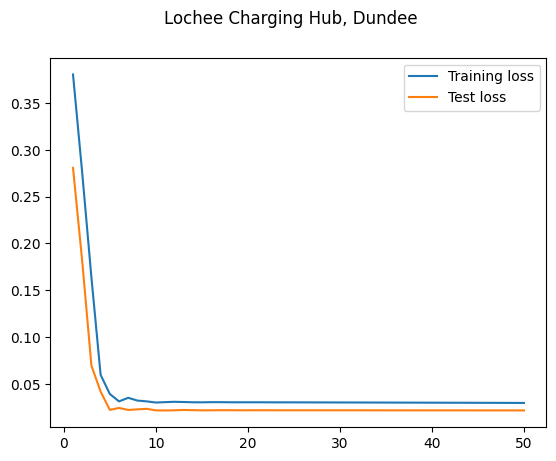

Lochee Charging Hub, Dundee Root Mean Squared Error (RMSE): 164.9985884652239

 Greenmarket Multi Car Park, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0233, Test Loss: 0.0132
Epoch [20/50] - Training Loss: 0.0192, Test Loss: 0.0100
Epoch [30/50] - Training Loss: 0.0182, Test Loss: 0.0097
Epoch [40/50] - Training Loss: 0.0178, Test Loss: 0.0097
Epoch [50/50] - Training Loss: 0.0175, Test Loss: 0.0098


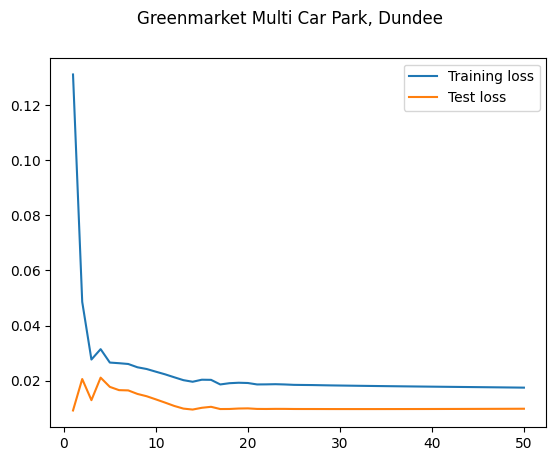

Greenmarket Multi Car Park, Dundee Root Mean Squared Error (RMSE): 40.68734405712979

 Queen Street Car Park, Broughty Ferry, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0308, Test Loss: 0.0236
Epoch [20/50] - Training Loss: 0.0281, Test Loss: 0.0249
Epoch [30/50] - Training Loss: 0.0252, Test Loss: 0.0240
Epoch [40/50] - Training Loss: 0.0254, Test Loss: 0.0250
Epoch [50/50] - Training Loss: 0.0248, Test Loss: 0.0243


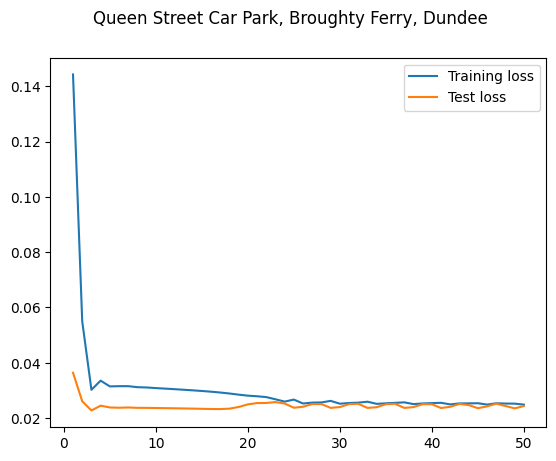

Queen Street Car Park, Broughty Ferry, Dundee Root Mean Squared Error (RMSE): 49.33874486690207

 Housing Office West, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0278, Test Loss: 0.0278
Epoch [20/50] - Training Loss: 0.0274, Test Loss: 0.0278
Epoch [30/50] - Training Loss: 0.0269, Test Loss: 0.0284
Epoch [40/50] - Training Loss: 0.0264, Test Loss: 0.0289
Epoch [50/50] - Training Loss: 0.0262, Test Loss: 0.0290


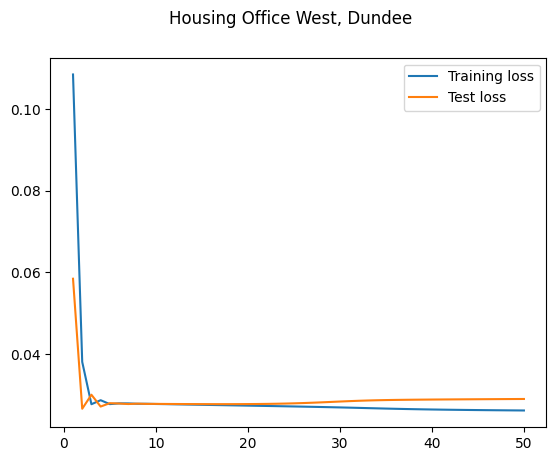

Housing Office West, Dundee Root Mean Squared Error (RMSE): 9.316362487711848

 Nethergate, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0185, Test Loss: 0.0187
Epoch [20/50] - Training Loss: 0.0185, Test Loss: 0.0188
Epoch [30/50] - Training Loss: 0.0185, Test Loss: 0.0188
Epoch [40/50] - Training Loss: 0.0185, Test Loss: 0.0188
Epoch [50/50] - Training Loss: 0.0185, Test Loss: 0.0188


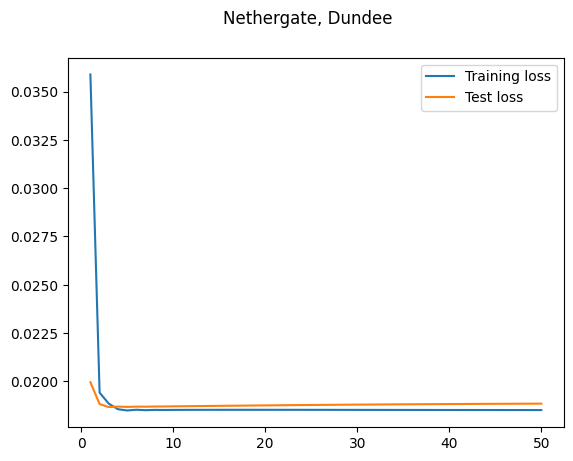

Nethergate, Dundee Root Mean Squared Error (RMSE): 12.030163944687935

 Brington Place Sheltered Housing, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0372, Test Loss: 0.0223
Epoch [20/50] - Training Loss: 0.0308, Test Loss: 0.0134
Epoch [30/50] - Training Loss: 0.0296, Test Loss: 0.0131
Epoch [40/50] - Training Loss: 0.0292, Test Loss: 0.0129
Epoch [50/50] - Training Loss: 0.0289, Test Loss: 0.0129


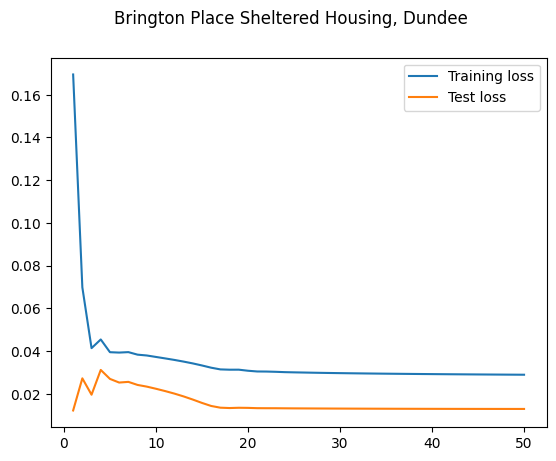

Brington Place Sheltered Housing, Dundee Root Mean Squared Error (RMSE): 4.788279583329073

 Balunie Drive, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0278, Test Loss: 0.0174
Epoch [20/50] - Training Loss: 0.0272, Test Loss: 0.0169
Epoch [30/50] - Training Loss: 0.0267, Test Loss: 0.0164
Epoch [40/50] - Training Loss: 0.0261, Test Loss: 0.0160
Epoch [50/50] - Training Loss: 0.0255, Test Loss: 0.0160


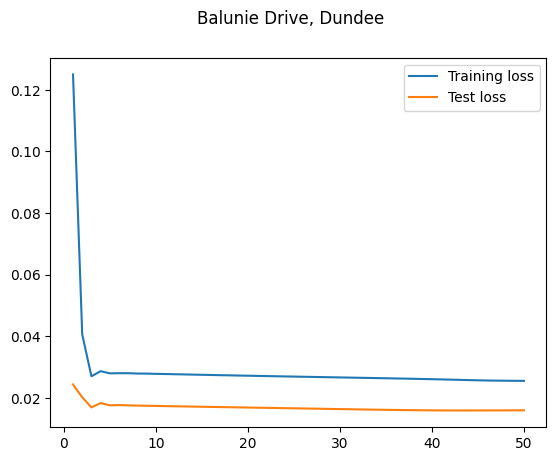

Balunie Drive, Dundee Root Mean Squared Error (RMSE): 9.429919044217902

 Social Work Building, Jack Martin Way, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0164, Test Loss: 0.0028
Epoch [20/50] - Training Loss: 0.0162, Test Loss: 0.0025
Epoch [30/50] - Training Loss: 0.0151, Test Loss: 0.0025
Epoch [40/50] - Training Loss: 0.0146, Test Loss: 0.0026
Epoch [50/50] - Training Loss: 0.0145, Test Loss: 0.0025


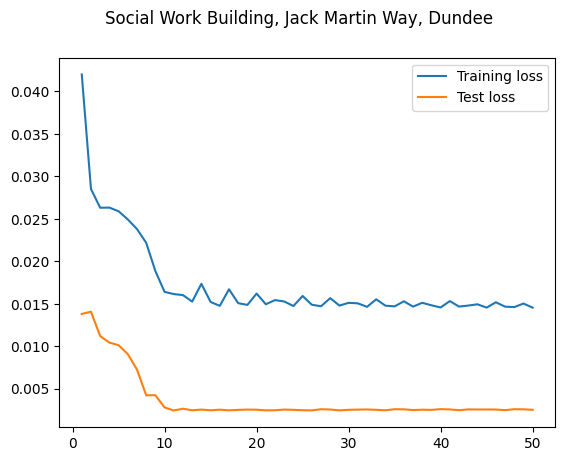

Social Work Building, Jack Martin Way, Dundee Root Mean Squared Error (RMSE): 7.62228435823984

 Dundee Ice Arena, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0355, Test Loss: 0.0146
Epoch [20/50] - Training Loss: 0.0229, Test Loss: 0.0082
Epoch [30/50] - Training Loss: 0.0209, Test Loss: 0.0083
Epoch [40/50] - Training Loss: 0.0200, Test Loss: 0.0085
Epoch [50/50] - Training Loss: 0.0194, Test Loss: 0.0087


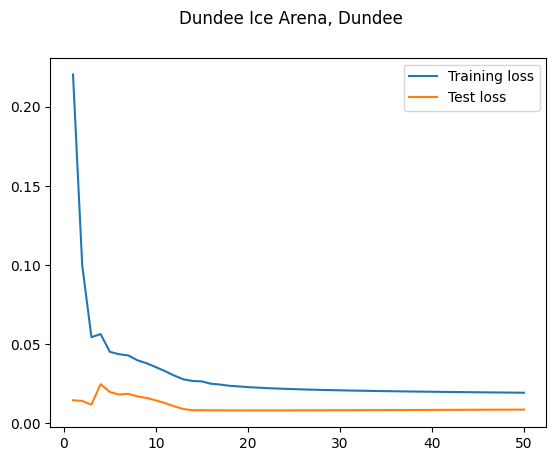

Dundee Ice Arena, Dundee Root Mean Squared Error (RMSE): 36.751470579091645

 Mitchell Street, Dundee 

(213, 30, 1) (213, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0092, Test Loss: 0.0056
Epoch [20/50] - Training Loss: 0.0092, Test Loss: 0.0057
Epoch [30/50] - Training Loss: 0.0091, Test Loss: 0.0057
Epoch [40/50] - Training Loss: 0.0091, Test Loss: 0.0057
Epoch [50/50] - Training Loss: 0.0091, Test Loss: 0.0057


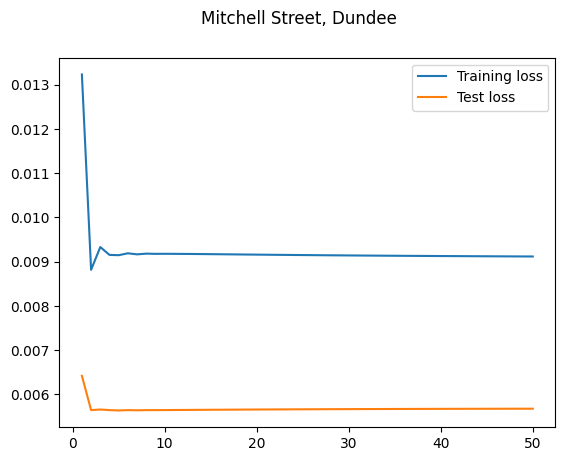

Mitchell Street, Dundee Root Mean Squared Error (RMSE): 4.793076779392828

 Oakland Day Centre, Dundee 

(218, 30, 1) (218, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0327, Test Loss: 0.0059
Epoch [20/50] - Training Loss: 0.0330, Test Loss: 0.0058
Epoch [30/50] - Training Loss: 0.0329, Test Loss: 0.0059
Epoch [40/50] - Training Loss: 0.0329, Test Loss: 0.0059
Epoch [50/50] - Training Loss: 0.0328, Test Loss: 0.0060


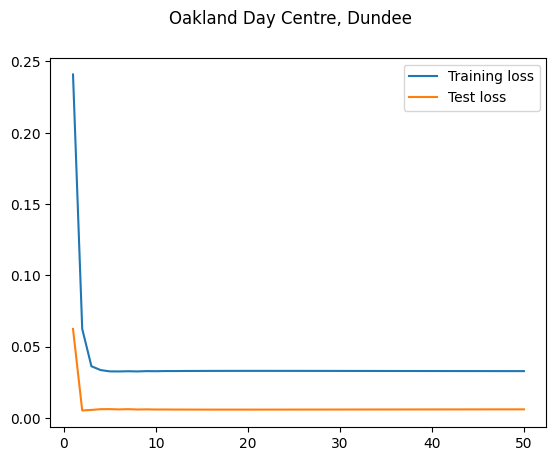

Oakland Day Centre, Dundee Root Mean Squared Error (RMSE): 3.8169163569702462

 Dock Street, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0130, Test Loss: 0.0440
Epoch [20/50] - Training Loss: 0.0129, Test Loss: 0.0442
Epoch [30/50] - Training Loss: 0.0129, Test Loss: 0.0444
Epoch [40/50] - Training Loss: 0.0128, Test Loss: 0.0445
Epoch [50/50] - Training Loss: 0.0128, Test Loss: 0.0446


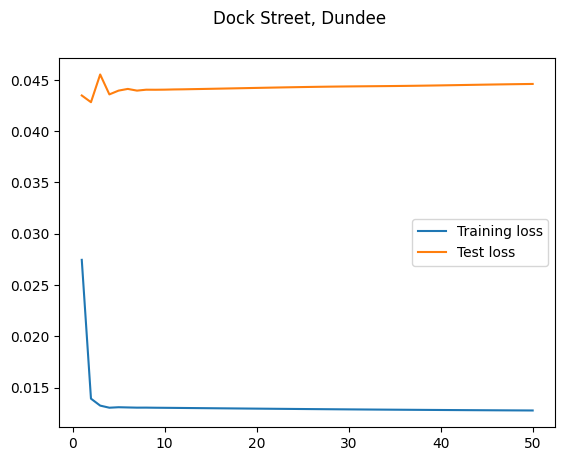

Dock Street, Dundee Root Mean Squared Error (RMSE): 21.282230246499374

 Whitfield Centre, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0392, Test Loss: 0.0583
Epoch [20/50] - Training Loss: 0.0385, Test Loss: 0.0567
Epoch [30/50] - Training Loss: 0.0378, Test Loss: 0.0555
Epoch [40/50] - Training Loss: 0.0363, Test Loss: 0.0562
Epoch [50/50] - Training Loss: 0.0334, Test Loss: 0.0563


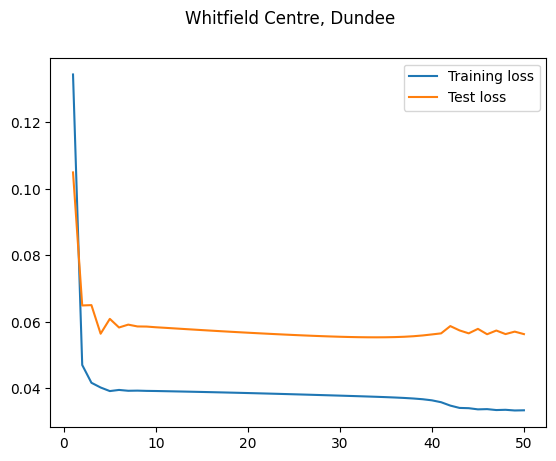

Whitfield Centre, Dundee Root Mean Squared Error (RMSE): 17.86451699163939

 Housing Office East, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0312, Test Loss: 0.0538
Epoch [20/50] - Training Loss: 0.0310, Test Loss: 0.0532
Epoch [30/50] - Training Loss: 0.0308, Test Loss: 0.0527
Epoch [40/50] - Training Loss: 0.0307, Test Loss: 0.0525
Epoch [50/50] - Training Loss: 0.0306, Test Loss: 0.0524


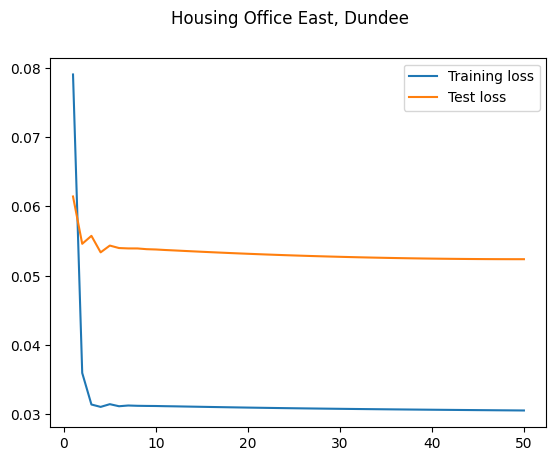

Housing Office East, Dundee Root Mean Squared Error (RMSE): 15.282596479458903

 Gellatly Street Car Park, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0348, Test Loss: 0.0202
Epoch [20/50] - Training Loss: 0.0344, Test Loss: 0.0202
Epoch [30/50] - Training Loss: 0.0341, Test Loss: 0.0202
Epoch [40/50] - Training Loss: 0.0338, Test Loss: 0.0202
Epoch [50/50] - Training Loss: 0.0335, Test Loss: 0.0205


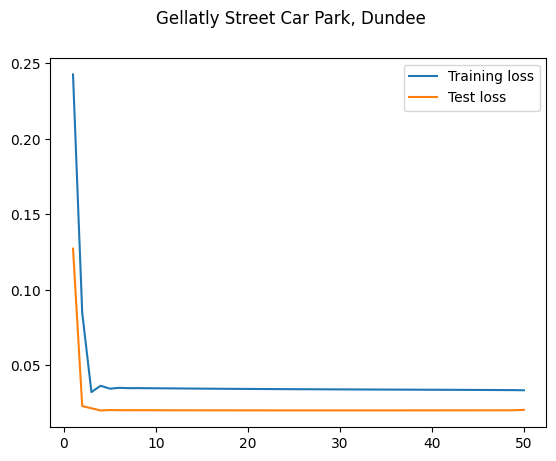

Gellatly Street Car Park, Dundee Root Mean Squared Error (RMSE): 23.17261485492002

 Public Works Dept, Clepington Rd. Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0527, Test Loss: 0.0121
Epoch [20/50] - Training Loss: 0.0063, Test Loss: 0.0025
Epoch [30/50] - Training Loss: 0.0096, Test Loss: 0.0035
Epoch [40/50] - Training Loss: 0.0076, Test Loss: 0.0026
Epoch [50/50] - Training Loss: 0.0067, Test Loss: 0.0025


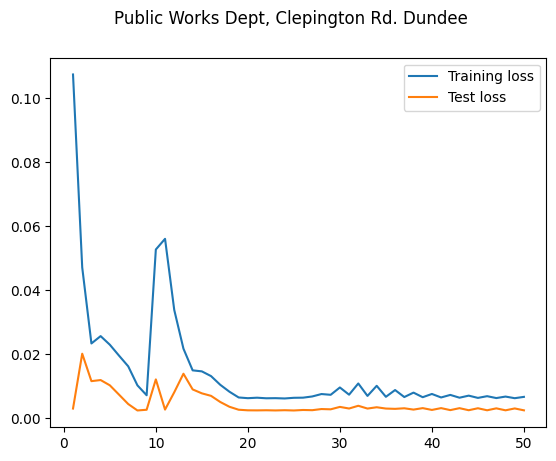

Public Works Dept, Clepington Rd. Dundee Root Mean Squared Error (RMSE): 16.557952958243224

 Marchbanks, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0380, Test Loss: 0.0399
Epoch [20/50] - Training Loss: 0.0381, Test Loss: 0.0399
Epoch [30/50] - Training Loss: 0.0380, Test Loss: 0.0399
Epoch [40/50] - Training Loss: 0.0380, Test Loss: 0.0398
Epoch [50/50] - Training Loss: 0.0380, Test Loss: 0.0398


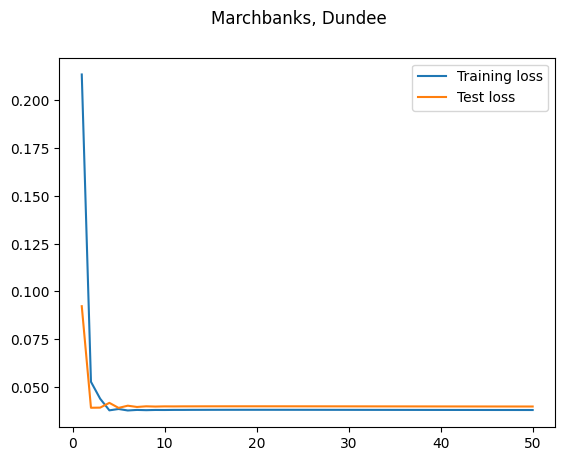

Marchbanks, Dundee Root Mean Squared Error (RMSE): 17.577201997808693

 Olympia Multi-Storey Car Park, Dundee 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0388, Test Loss: 0.0173
Epoch [20/50] - Training Loss: 0.0367, Test Loss: 0.0159
Epoch [30/50] - Training Loss: 0.0351, Test Loss: 0.0158
Epoch [40/50] - Training Loss: 0.0345, Test Loss: 0.0157
Epoch [50/50] - Training Loss: 0.0331, Test Loss: 0.0154


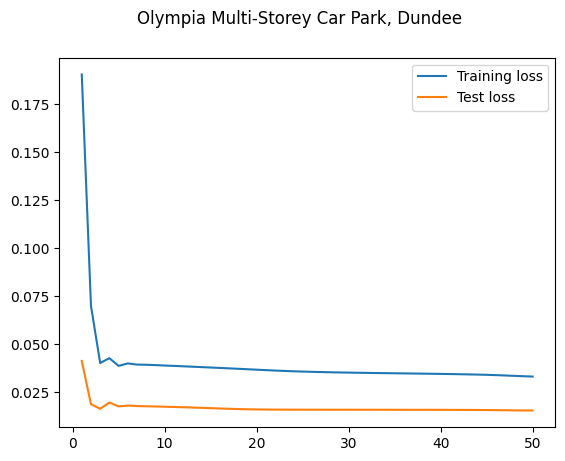

Olympia Multi-Storey Car Park, Dundee Root Mean Squared Error (RMSE): 12.938706588091613

 South Tay Street 

(219, 30, 1) (219, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0359, Test Loss: 0.0472
Epoch [20/50] - Training Loss: 0.0358, Test Loss: 0.0472
Epoch [30/50] - Training Loss: 0.0355, Test Loss: 0.0468
Epoch [40/50] - Training Loss: 0.0352, Test Loss: 0.0464
Epoch [50/50] - Training Loss: 0.0350, Test Loss: 0.0469


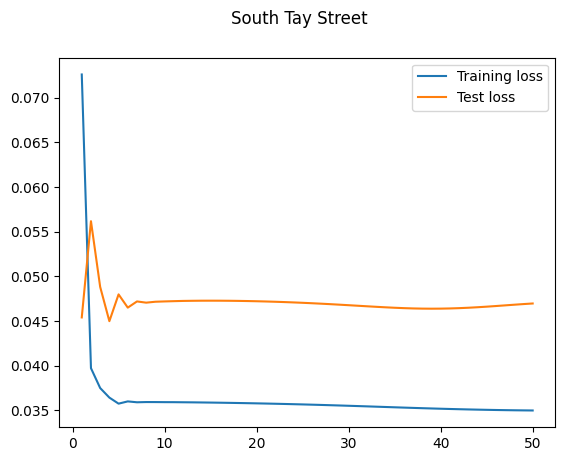

South Tay Street Root Mean Squared Error (RMSE): 18.99321855701894

 Ardler Complex, Dundee 

(216, 30, 1) (216, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0107, Test Loss: 0.0398
Epoch [20/50] - Training Loss: 0.0107, Test Loss: 0.0399
Epoch [30/50] - Training Loss: 0.0105, Test Loss: 0.0400
Epoch [40/50] - Training Loss: 0.0103, Test Loss: 0.0402
Epoch [50/50] - Training Loss: 0.0102, Test Loss: 0.0405


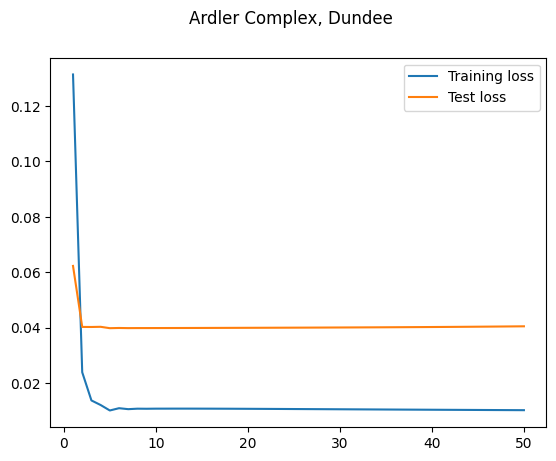

Ardler Complex, Dundee Root Mean Squared Error (RMSE): 6.4909166127689195

 Menziehill House, Dundee 

(218, 30, 1) (218, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0210, Test Loss: 0.0184
Epoch [20/50] - Training Loss: 0.0197, Test Loss: 0.0191
Epoch [30/50] - Training Loss: 0.0188, Test Loss: 0.0197
Epoch [40/50] - Training Loss: 0.0186, Test Loss: 0.0199
Epoch [50/50] - Training Loss: 0.0185, Test Loss: 0.0201


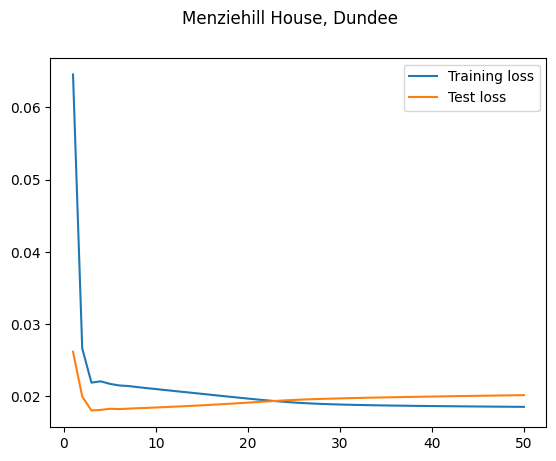

Menziehill House, Dundee Root Mean Squared Error (RMSE): 10.364321948536558

 Turriff House Rannoch Road, Dundee 

(204, 30, 1) (204, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0163, Test Loss: 0.0129
Epoch [20/50] - Training Loss: 0.0157, Test Loss: 0.0132
Epoch [30/50] - Training Loss: 0.0151, Test Loss: 0.0136
Epoch [40/50] - Training Loss: 0.0146, Test Loss: 0.0139
Epoch [50/50] - Training Loss: 0.0141, Test Loss: 0.0142


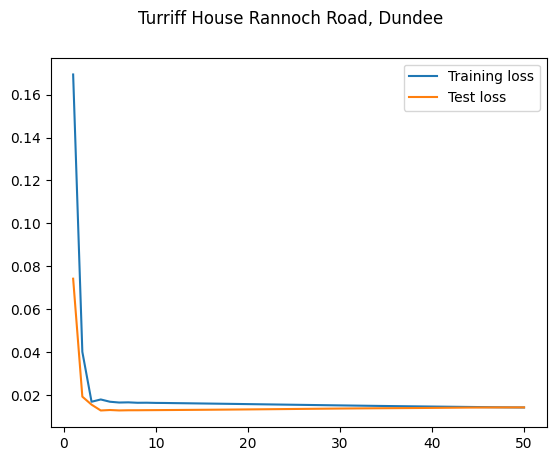

Turriff House Rannoch Road, Dundee Root Mean Squared Error (RMSE): 4.947863650291238

 Trades Lane 

(156, 30, 1) (156, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0279, Test Loss: 0.0229
Epoch [20/50] - Training Loss: 0.0276, Test Loss: 0.0225
Epoch [30/50] - Training Loss: 0.0269, Test Loss: 0.0215
Epoch [40/50] - Training Loss: 0.0259, Test Loss: 0.0216
Epoch [50/50] - Training Loss: 0.0256, Test Loss: 0.0222


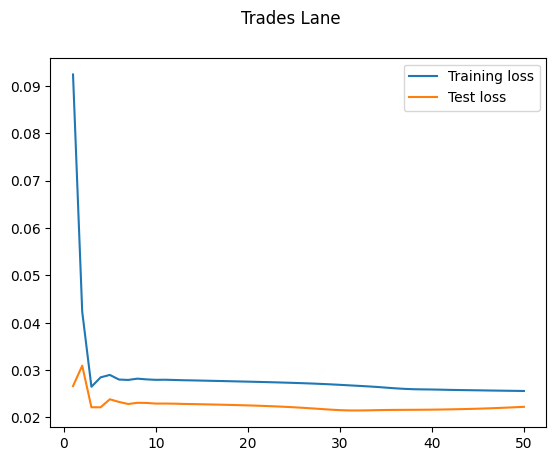

Trades Lane Root Mean Squared Error (RMSE): 13.253962292549343

 University of Dundee, Nethergate, Dundee 

(153, 30, 1) (153, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0321, Test Loss: 0.0539
Epoch [20/50] - Training Loss: 0.0320, Test Loss: 0.0537
Epoch [30/50] - Training Loss: 0.0317, Test Loss: 0.0529
Epoch [40/50] - Training Loss: 0.0313, Test Loss: 0.0527
Epoch [50/50] - Training Loss: 0.0311, Test Loss: 0.0528


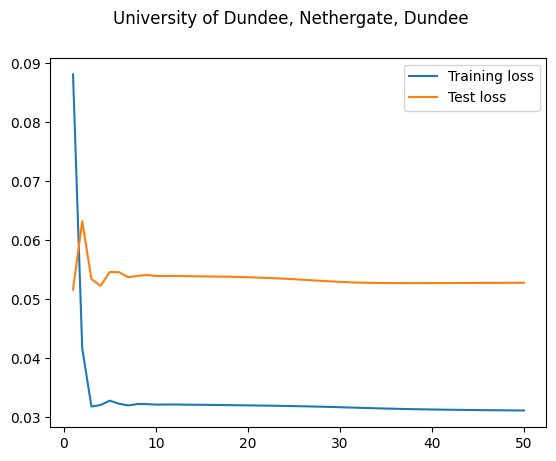

University of Dundee, Nethergate, Dundee Root Mean Squared Error (RMSE): 13.021660908992514

 Janet Brougham House, Dundee 

(64, 30, 1) (64, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0292, Test Loss: 0.0407
Epoch [20/50] - Training Loss: 0.0278, Test Loss: 0.0382
Epoch [30/50] - Training Loss: 0.0277, Test Loss: 0.0381
Epoch [40/50] - Training Loss: 0.0276, Test Loss: 0.0382
Epoch [50/50] - Training Loss: 0.0275, Test Loss: 0.0384


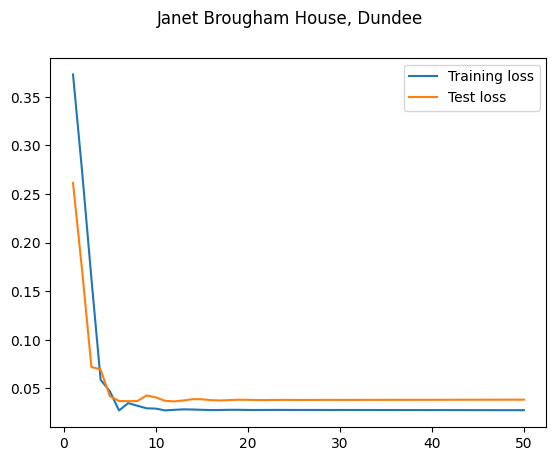

Janet Brougham House, Dundee Root Mean Squared Error (RMSE): 8.739727265978619

 DCC Environment, 34 Harefield Road 

(32, 30, 1) (32, 1) (30, 30, 1) (30, 1)
Epoch [10/50] - Training Loss: 0.0361, Test Loss: 0.0704


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/50] - Training Loss: 0.0360, Test Loss: 0.0721
Epoch [30/50] - Training Loss: 0.0359, Test Loss: 0.0739
Epoch [40/50] - Training Loss: 0.0358, Test Loss: 0.0736
Epoch [50/50] - Training Loss: 0.0357, Test Loss: 0.0733


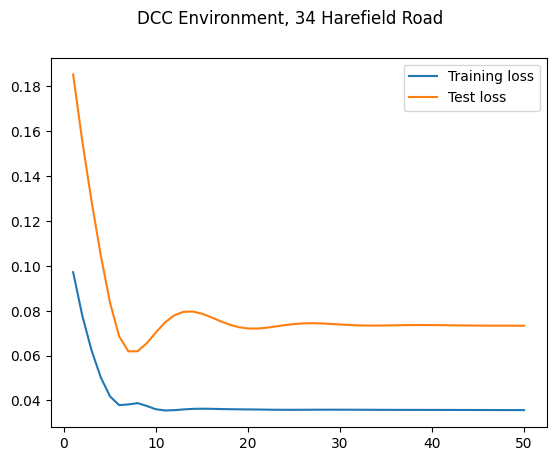

DCC Environment, 34 Harefield Road Root Mean Squared Error (RMSE): 13.598933498694555

 Sinclair Street 

(36, 30, 1) (36, 1) (30, 30, 1) (30, 1)
Epoch [10/50] - Training Loss: 0.0317, Test Loss: 0.0498

c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Epoch [20/50] - Training Loss: 0.0309, Test Loss: 0.0497
Epoch [30/50] - Training Loss: 0.0308, Test Loss: 0.0494
Epoch [40/50] - Training Loss: 0.0307, Test Loss: 0.0494
Epoch [50/50] - Training Loss: 0.0306, Test Loss: 0.0494


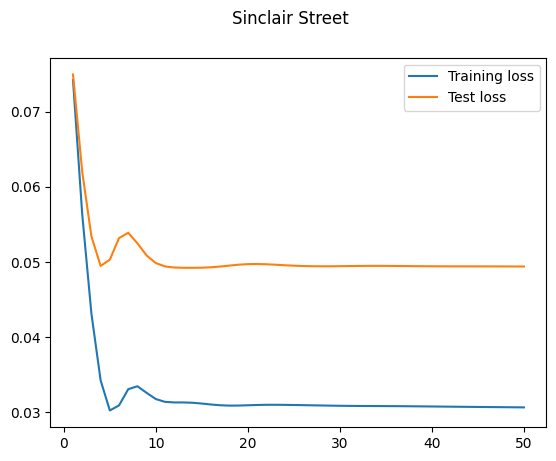

Sinclair Street Root Mean Squared Error (RMSE): 15.843001711330908

 Earn Cresent, Dundee 

(35, 30, 1) (35, 1) (30, 30, 1) (30, 1)
Epoch [10/50] - Training Loss: 0.0325, Test Loss: 0.0297


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/50] - Training Loss: 0.0296, Test Loss: 0.0292
Epoch [30/50] - Training Loss: 0.0293, Test Loss: 0.0301
Epoch [40/50] - Training Loss: 0.0292, Test Loss: 0.0302
Epoch [50/50] - Training Loss: 0.0291, Test Loss: 0.0305


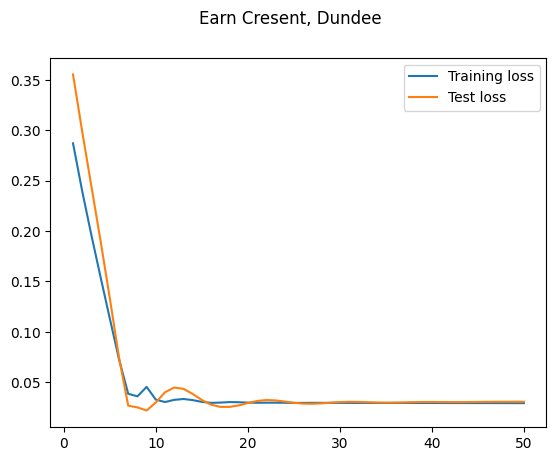

Earn Cresent, Dundee Root Mean Squared Error (RMSE): 6.389268807672591


In [27]:
train_lstm(df_dict=stations_dict, type='daily', sequence_length=30, stations=stations, 
           num_epochs=50, predictions_dict=daily_predictions_dict, test_obs=30)

In [28]:
# File path to save the dictionary
file_path = 'daily_predictions_dundee.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'daily_predictions_dundee.pkl'


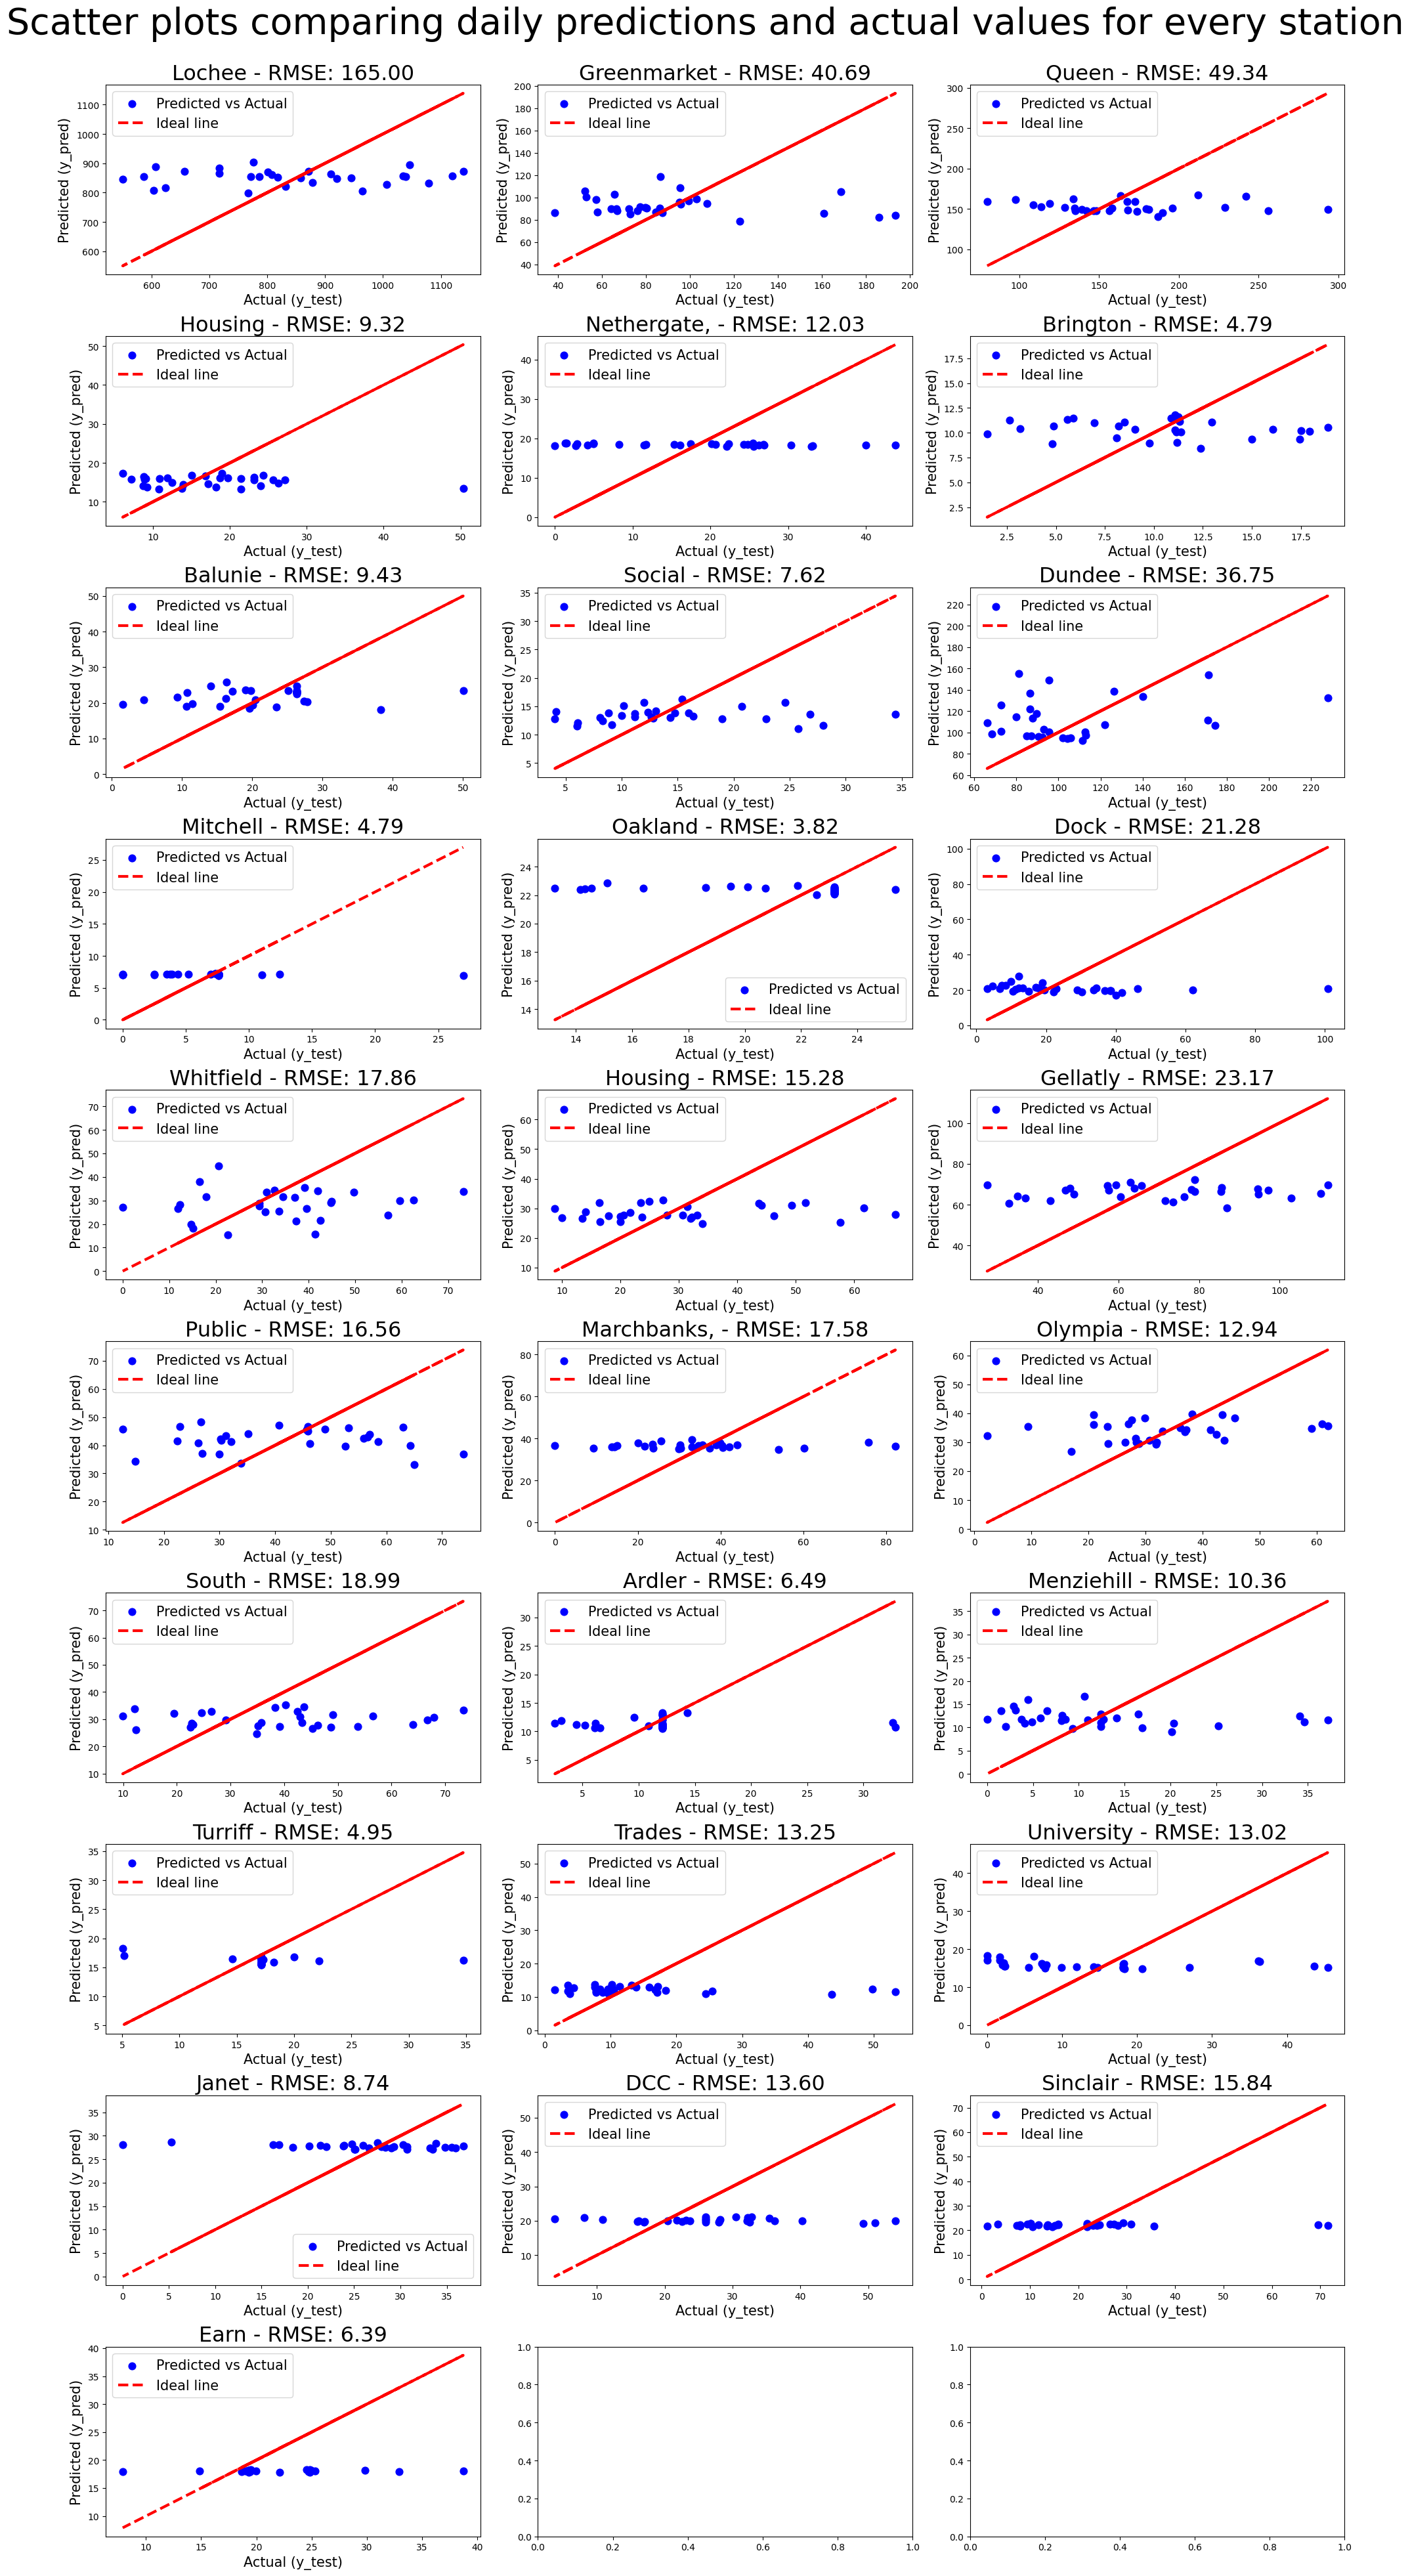

In [54]:
# Define the number of rows and columns for subplots
n_rows = 10
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 40))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(daily_predictions_dict.keys()):
    # Get data for the current station
    station_data = daily_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', s=60)
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line', linewidth=3)

    axs[i].set_title(f'{station.split()[0]} - RMSE: {rmse:.2f}', fontsize=23)
    axs[i].set_xlabel('Actual (y_test)', fontsize=15)
    axs[i].set_ylabel('Predicted (y_pred)', fontsize=15)
    axs[i].legend(fontsize=15)

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Scatter plots comparing daily predictions and actual values for every station', fontsize=40)
plt.show()

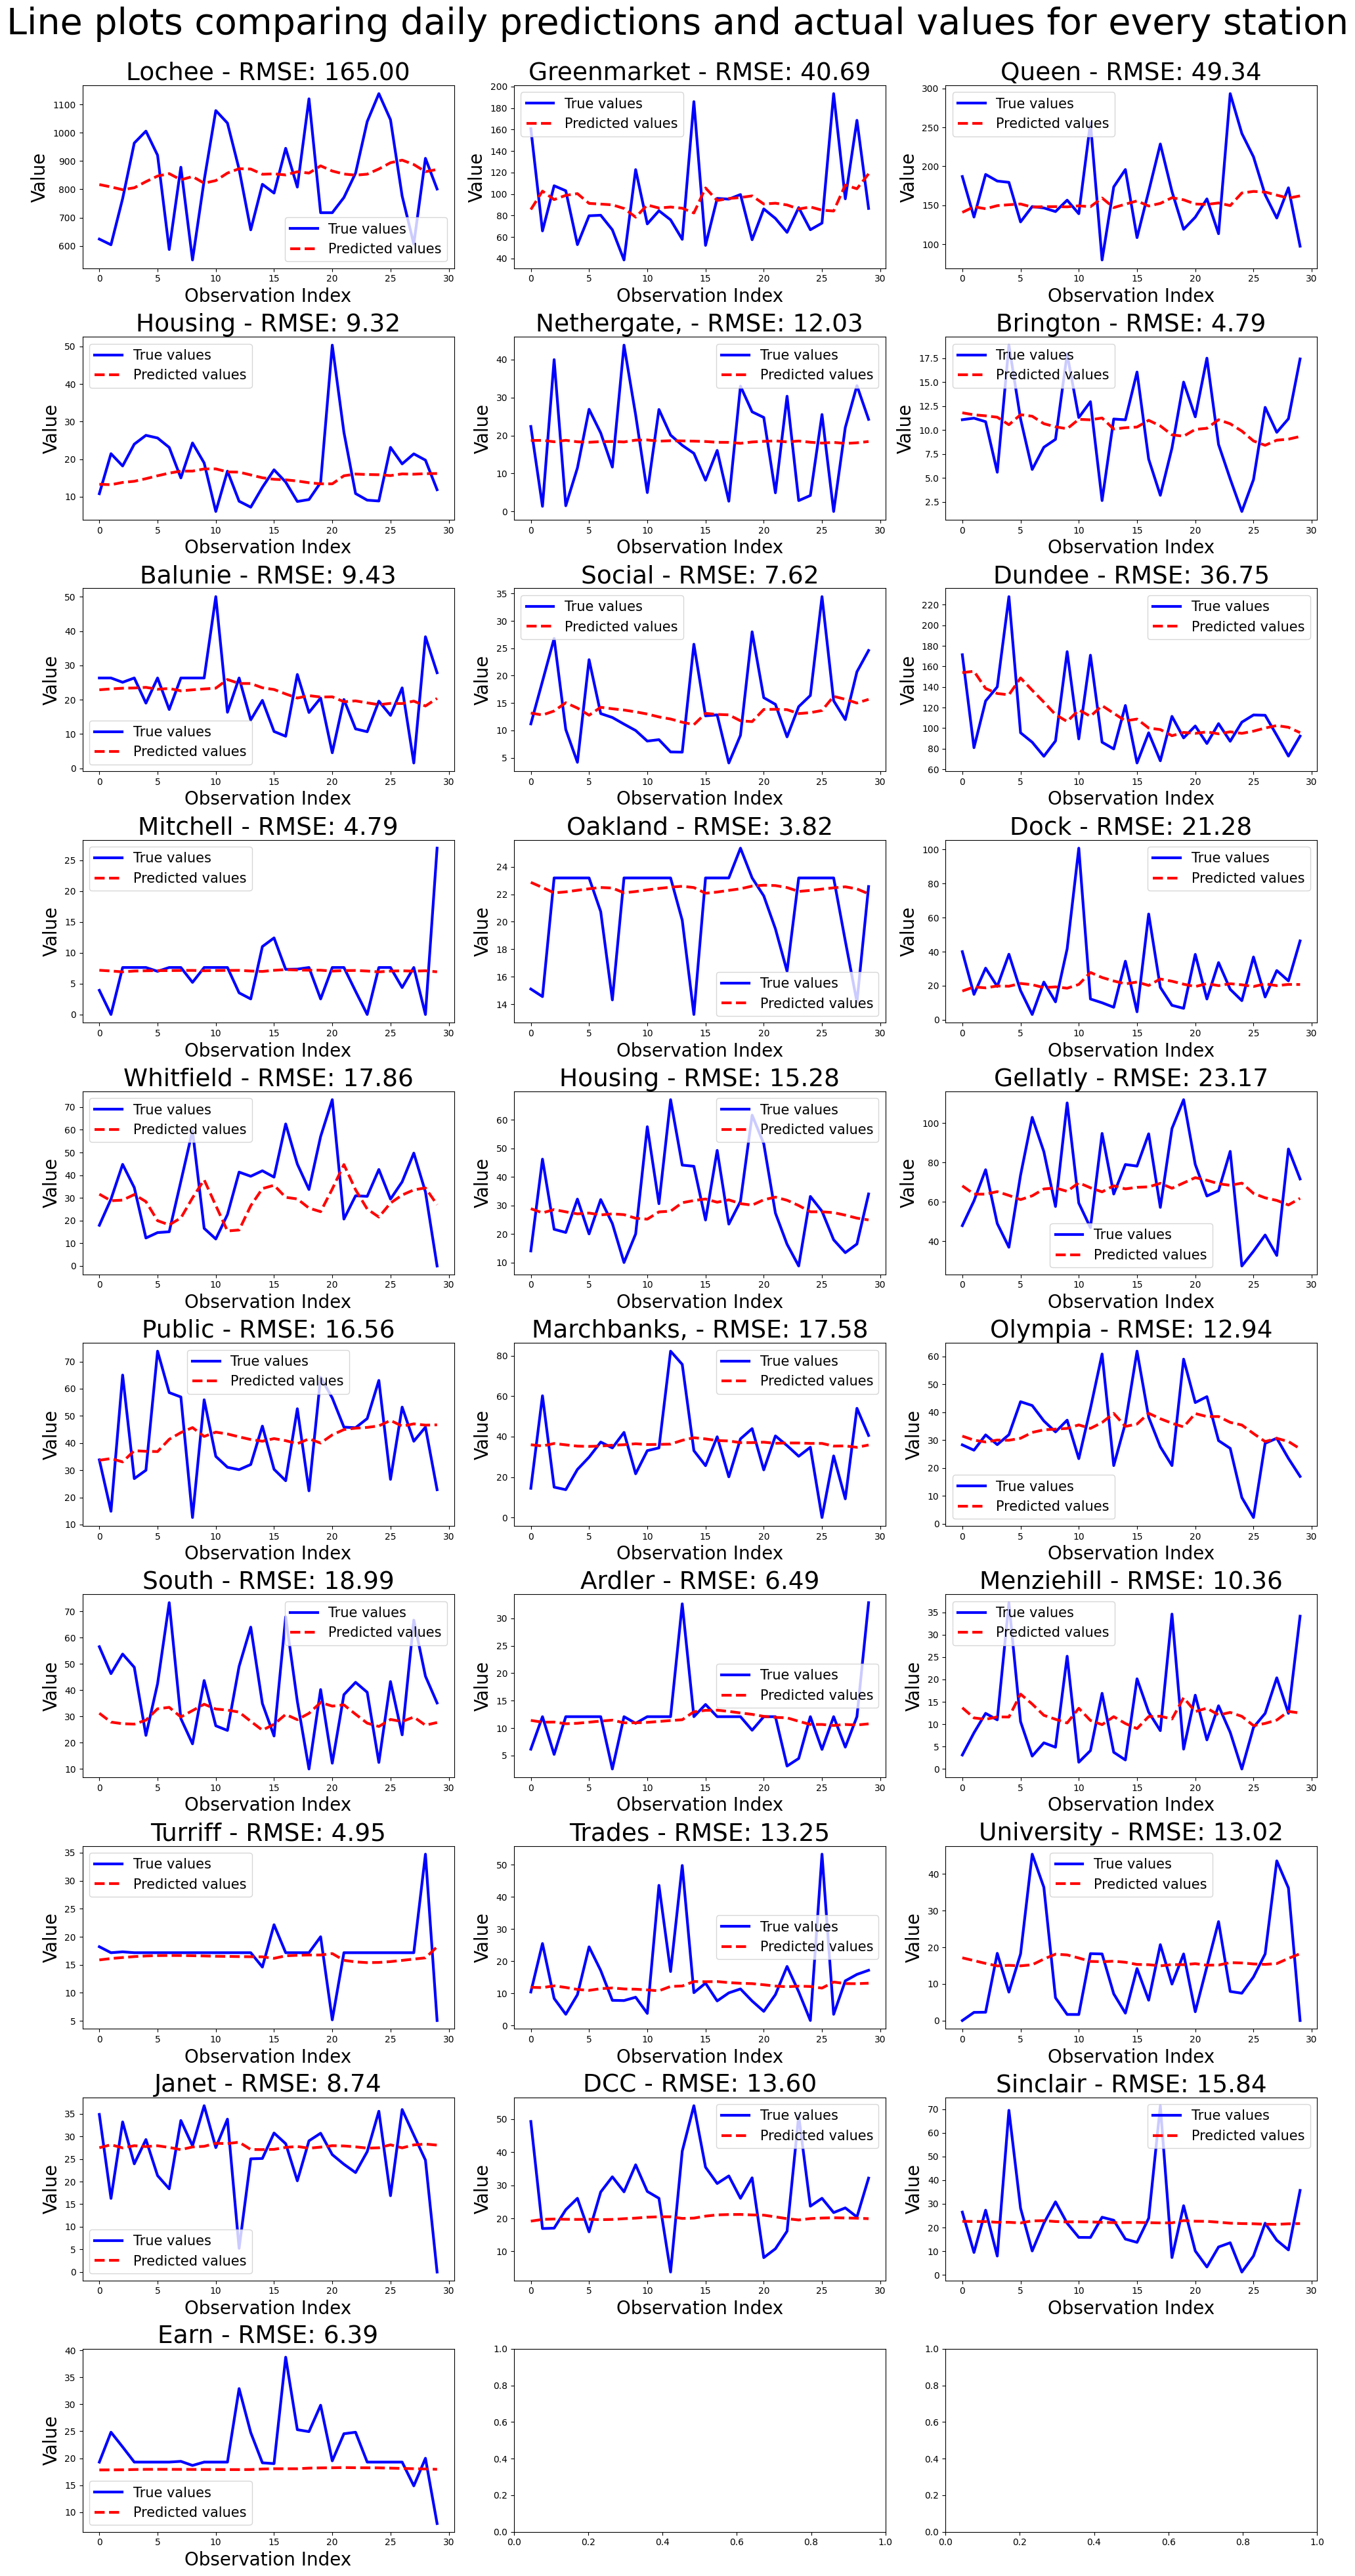

In [48]:
# Define the number of rows and columns for subplots
n_rows = 10
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 40))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(daily_predictions_dict.keys()):
    # Get data for the current station
    station_data = daily_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values', linewidth=3)
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values', linewidth=3)

    axs[i].set_title(f'{station.split()[0]} - RMSE: {rmse:.2f}', fontsize=27)
    axs[i].set_xlabel('Observation Index', fontsize=20)
    axs[i].set_ylabel('Value', fontsize=20)
    axs[i].legend(fontsize=15)

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Line plots comparing daily predictions and actual values for every station', fontsize=40)
plt.show()


The predictions aren't satisfactory. On average the results are not bad but the forecasts seem unimpacted by the sudden spikes and stay flat. Expectations from the LSTM were certainly higher but the model was limited by the significantly shorter timeframe of training data compared to the other cities.

### Weekly LSTM model

Weekly model is trained to predict based on just 5 previous observations (limited by the timeframe of dataset). Test set contains last 12 observations (rest is used for training). It is for 100 epochs to avoid overfitting. Several stations were dropped due to insufficent number of observations. The training output has been colapsed as it used only for diagnostics. Results are shown at the end.

In [56]:
# Initialize dict for storing predictions
weekly_predictions_dict = {}
for station in stations:
    weekly_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}


 Lochee Charging Hub, Dundee 

(5, 5, 1) (5, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.3251, Test Loss: 0.2133
Epoch [20/100] - Training Loss: 0.1461, Test Loss: 0.0896
Epoch [30/100] - Training Loss: 0.0180, Test Loss: 0.0959
Epoch [40/100] - Training Loss: 0.0239, Test Loss: 0.0927


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [50/100] - Training Loss: 0.0220, Test Loss: 0.0589
Epoch [60/100] - Training Loss: 0.0178, Test Loss: 0.0731
Epoch [70/100] - Training Loss: 0.0184, Test Loss: 0.0807
Epoch [80/100] - Training Loss: 0.0178, Test Loss: 0.0702
Epoch [90/100] - Training Loss: 0.0177, Test Loss: 0.0736
Epoch [100/100] - Training Loss: 0.0177, Test Loss: 0.0750


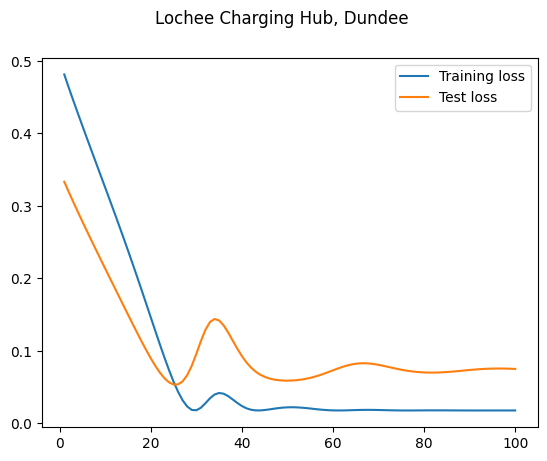

Lochee Charging Hub, Dundee Root Mean Squared Error (RMSE): 1410.1596638025185

 Greenmarket Multi Car Park, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0414, Test Loss: 0.0362
Epoch [20/100] - Training Loss: 0.0336, Test Loss: 0.0594
Epoch [30/100] - Training Loss: 0.0317, Test Loss: 0.0426


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [40/100] - Training Loss: 0.0302, Test Loss: 0.0428
Epoch [50/100] - Training Loss: 0.0288, Test Loss: 0.0373
Epoch [60/100] - Training Loss: 0.0275, Test Loss: 0.0328
Epoch [70/100] - Training Loss: 0.0263, Test Loss: 0.0280
Epoch [80/100] - Training Loss: 0.0254, Test Loss: 0.0240
Epoch [90/100] - Training Loss: 0.0248, Test Loss: 0.0212
Epoch [100/100] - Training Loss: 0.0243, Test Loss: 0.0199


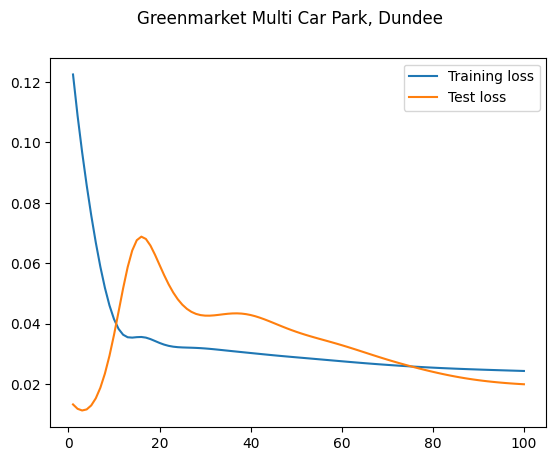

Greenmarket Multi Car Park, Dundee Root Mean Squared Error (RMSE): 255.5779040304386

 Queen Street Car Park, Broughty Ferry, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0447, Test Loss: 0.0398
Epoch [20/100] - Training Loss: 0.0355, Test Loss: 0.0570


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0346, Test Loss: 0.0475
Epoch [40/100] - Training Loss: 0.0325, Test Loss: 0.0458
Epoch [50/100] - Training Loss: 0.0306, Test Loss: 0.0395
Epoch [60/100] - Training Loss: 0.0282, Test Loss: 0.0317
Epoch [70/100] - Training Loss: 0.0260, Test Loss: 0.0232
Epoch [80/100] - Training Loss: 0.0253, Test Loss: 0.0176
Epoch [90/100] - Training Loss: 0.0252, Test Loss: 0.0172
Epoch [100/100] - Training Loss: 0.0251, Test Loss: 0.0179


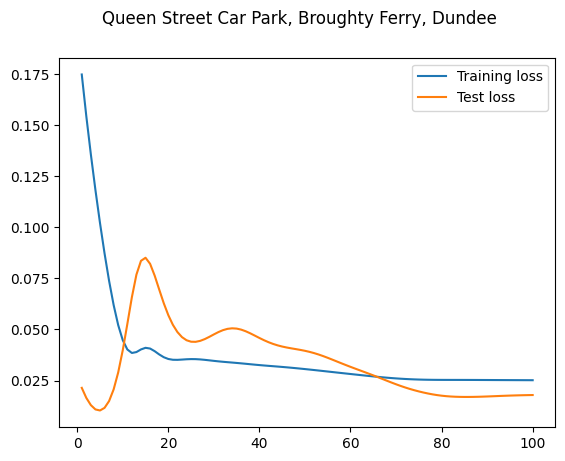

Queen Street Car Park, Broughty Ferry, Dundee Root Mean Squared Error (RMSE): 133.23601466232165

 Housing Office West, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0615, Test Loss: 0.0340
Epoch [20/100] - Training Loss: 0.0472, Test Loss: 0.0255


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0466, Test Loss: 0.0257
Epoch [40/100] - Training Loss: 0.0457, Test Loss: 0.0251
Epoch [50/100] - Training Loss: 0.0453, Test Loss: 0.0252
Epoch [60/100] - Training Loss: 0.0449, Test Loss: 0.0250
Epoch [70/100] - Training Loss: 0.0445, Test Loss: 0.0250
Epoch [80/100] - Training Loss: 0.0442, Test Loss: 0.0249
Epoch [90/100] - Training Loss: 0.0438, Test Loss: 0.0249
Epoch [100/100] - Training Loss: 0.0435, Test Loss: 0.0249


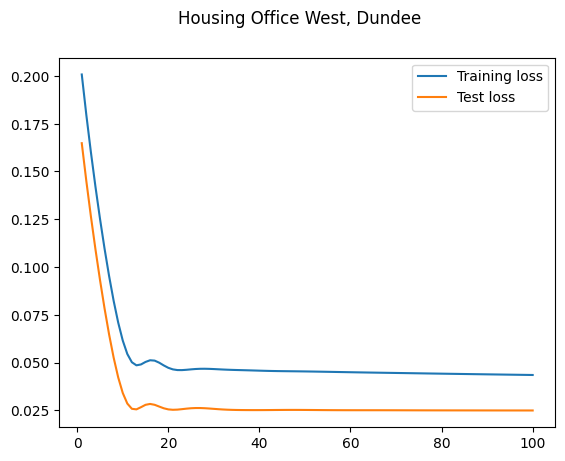

Housing Office West, Dundee Root Mean Squared Error (RMSE): 23.166639027729374

 Nethergate, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0663, Test Loss: 0.0390
Epoch [20/100] - Training Loss: 0.0444, Test Loss: 0.0314


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0438, Test Loss: 0.0319
Epoch [40/100] - Training Loss: 0.0436, Test Loss: 0.0311
Epoch [50/100] - Training Loss: 0.0433, Test Loss: 0.0315
Epoch [60/100] - Training Loss: 0.0430, Test Loss: 0.0313
Epoch [70/100] - Training Loss: 0.0426, Test Loss: 0.0312
Epoch [80/100] - Training Loss: 0.0421, Test Loss: 0.0312
Epoch [90/100] - Training Loss: 0.0415, Test Loss: 0.0311
Epoch [100/100] - Training Loss: 0.0409, Test Loss: 0.0311


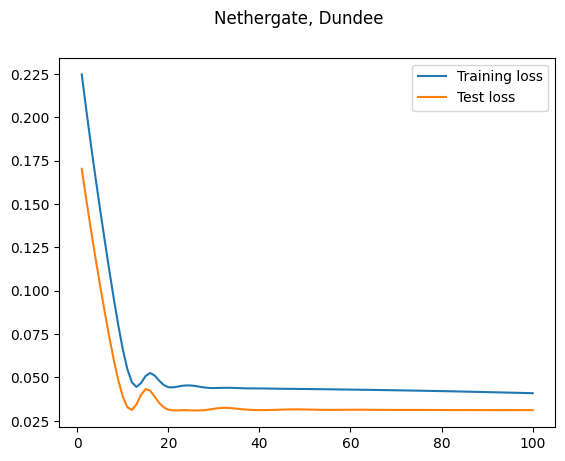

Nethergate, Dundee Root Mean Squared Error (RMSE): 32.89921486075716

 Brington Place Sheltered Housing, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0797, Test Loss: 0.0358
Epoch [20/100] - Training Loss: 0.0532, Test Loss: 0.0972
Epoch [30/100] - Training Loss: 0.0501, Test Loss: 0.0637


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [40/100] - Training Loss: 0.0479, Test Loss: 0.0675
Epoch [50/100] - Training Loss: 0.0459, Test Loss: 0.0584
Epoch [60/100] - Training Loss: 0.0439, Test Loss: 0.0525
Epoch [70/100] - Training Loss: 0.0416, Test Loss: 0.0449
Epoch [80/100] - Training Loss: 0.0390, Test Loss: 0.0367
Epoch [90/100] - Training Loss: 0.0358, Test Loss: 0.0273
Epoch [100/100] - Training Loss: 0.0318, Test Loss: 0.0174


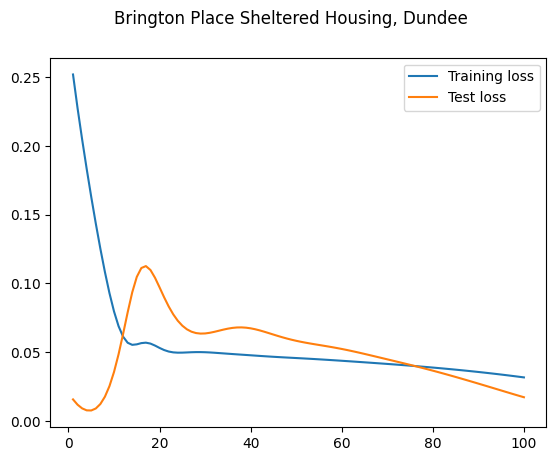

Brington Place Sheltered Housing, Dundee Root Mean Squared Error (RMSE): 22.368145045013396

 Balunie Drive, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0777, Test Loss: 0.0220
Epoch [20/100] - Training Loss: 0.0694, Test Loss: 0.0250


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0616, Test Loss: 0.0159
Epoch [40/100] - Training Loss: 0.0525, Test Loss: 0.0111
Epoch [50/100] - Training Loss: 0.0463, Test Loss: 0.0082
Epoch [60/100] - Training Loss: 0.0452, Test Loss: 0.0092
Epoch [70/100] - Training Loss: 0.0440, Test Loss: 0.0088
Epoch [80/100] - Training Loss: 0.0429, Test Loss: 0.0089
Epoch [90/100] - Training Loss: 0.0418, Test Loss: 0.0091
Epoch [100/100] - Training Loss: 0.0407, Test Loss: 0.0092


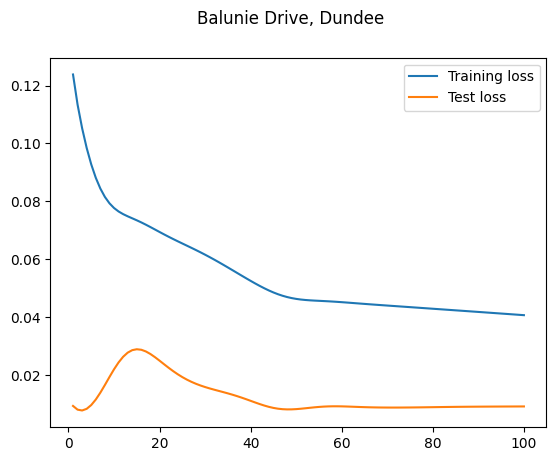

Balunie Drive, Dundee Root Mean Squared Error (RMSE): 27.08216498973722

 Social Work Building, Jack Martin Way, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.1338, Test Loss: 0.0039
Epoch [20/100] - Training Loss: 0.0715, Test Loss: 0.0795


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0562, Test Loss: 0.0347
Epoch [40/100] - Training Loss: 0.0451, Test Loss: 0.0285
Epoch [50/100] - Training Loss: 0.0345, Test Loss: 0.0130
Epoch [60/100] - Training Loss: 0.0272, Test Loss: 0.0036
Epoch [70/100] - Training Loss: 0.0250, Test Loss: 0.0012
Epoch [80/100] - Training Loss: 0.0248, Test Loss: 0.0013
Epoch [90/100] - Training Loss: 0.0247, Test Loss: 0.0012
Epoch [100/100] - Training Loss: 0.0246, Test Loss: 0.0012


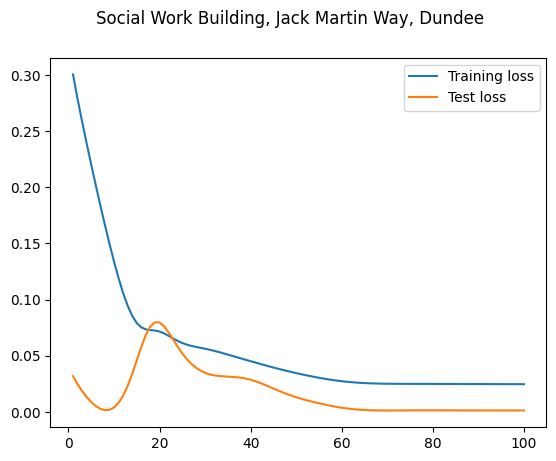

Social Work Building, Jack Martin Way, Dundee Root Mean Squared Error (RMSE): 16.36219847189861

 Dundee Ice Arena, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.2677, Test Loss: 0.0194
Epoch [20/100] - Training Loss: 0.0818, Test Loss: 0.1526


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0657, Test Loss: 0.0725
Epoch [40/100] - Training Loss: 0.0602, Test Loss: 0.0730
Epoch [50/100] - Training Loss: 0.0534, Test Loss: 0.0534
Epoch [60/100] - Training Loss: 0.0469, Test Loss: 0.0394
Epoch [70/100] - Training Loss: 0.0399, Test Loss: 0.0257
Epoch [80/100] - Training Loss: 0.0337, Test Loss: 0.0181
Epoch [90/100] - Training Loss: 0.0297, Test Loss: 0.0192
Epoch [100/100] - Training Loss: 0.0282, Test Loss: 0.0249


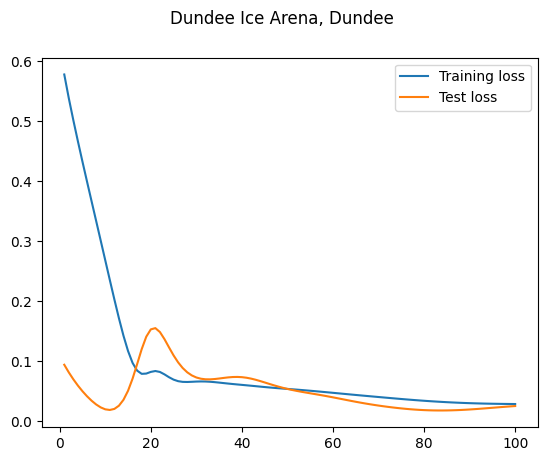

Dundee Ice Arena, Dundee Root Mean Squared Error (RMSE): 303.61553336319054

 Mitchell Street, Dundee 

(22, 5, 1) (22, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0950, Test Loss: 0.0214
Epoch [20/100] - Training Loss: 0.0650, Test Loss: 0.0215


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0635, Test Loss: 0.0226
Epoch [40/100] - Training Loss: 0.0636, Test Loss: 0.0213
Epoch [50/100] - Training Loss: 0.0632, Test Loss: 0.0230
Epoch [60/100] - Training Loss: 0.0629, Test Loss: 0.0227
Epoch [70/100] - Training Loss: 0.0627, Test Loss: 0.0232
Epoch [80/100] - Training Loss: 0.0624, Test Loss: 0.0236
Epoch [90/100] - Training Loss: 0.0621, Test Loss: 0.0240
Epoch [100/100] - Training Loss: 0.0619, Test Loss: 0.0244


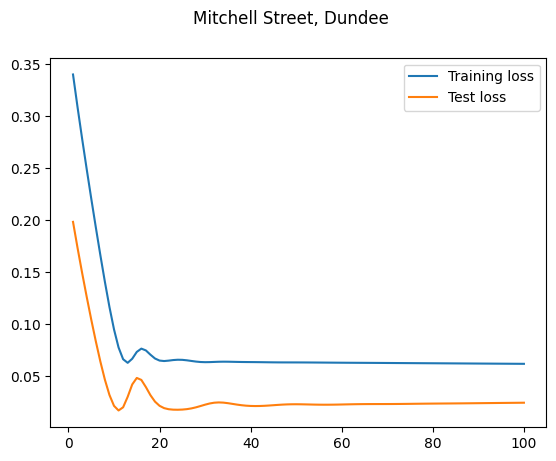

Mitchell Street, Dundee Root Mean Squared Error (RMSE): 9.950468331446995

 Oakland Day Centre, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0816, Test Loss: 0.0480
Epoch [20/100] - Training Loss: 0.0459, Test Loss: 0.1493


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0420, Test Loss: 0.1123
Epoch [40/100] - Training Loss: 0.0417, Test Loss: 0.1243
Epoch [50/100] - Training Loss: 0.0414, Test Loss: 0.1207
Epoch [60/100] - Training Loss: 0.0414, Test Loss: 0.1209
Epoch [70/100] - Training Loss: 0.0412, Test Loss: 0.1208
Epoch [80/100] - Training Loss: 0.0411, Test Loss: 0.1205
Epoch [90/100] - Training Loss: 0.0409, Test Loss: 0.1205
Epoch [100/100] - Training Loss: 0.0407, Test Loss: 0.1206


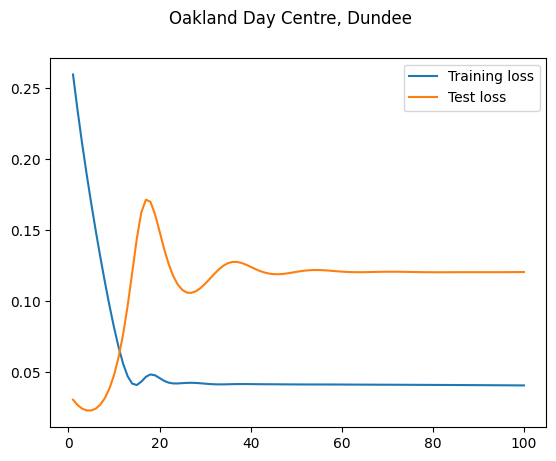

Oakland Day Centre, Dundee Root Mean Squared Error (RMSE): 65.15448532055676

 Dock Street, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0537, Test Loss: 0.1402
Epoch [20/100] - Training Loss: 0.0392, Test Loss: 0.0890


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0385, Test Loss: 0.0925
Epoch [40/100] - Training Loss: 0.0380, Test Loss: 0.0947
Epoch [50/100] - Training Loss: 0.0375, Test Loss: 0.0933
Epoch [60/100] - Training Loss: 0.0368, Test Loss: 0.0964
Epoch [70/100] - Training Loss: 0.0358, Test Loss: 0.0992
Epoch [80/100] - Training Loss: 0.0345, Test Loss: 0.1043
Epoch [90/100] - Training Loss: 0.0327, Test Loss: 0.1144
Epoch [100/100] - Training Loss: 0.0308, Test Loss: 0.1333


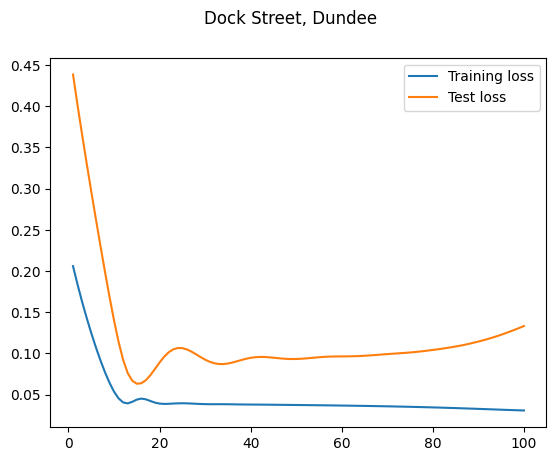

Dock Street, Dundee Root Mean Squared Error (RMSE): 64.16653097462132

 Whitfield Centre, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.1202, Test Loss: 0.1512
Epoch [20/100] - Training Loss: 0.0566, Test Loss: 0.1093
Epoch [30/100] - Training Loss: 0.0542, Test Loss: 0.1085


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [40/100] - Training Loss: 0.0528, Test Loss: 0.1084
Epoch [50/100] - Training Loss: 0.0521, Test Loss: 0.1087
Epoch [60/100] - Training Loss: 0.0511, Test Loss: 0.1088
Epoch [70/100] - Training Loss: 0.0499, Test Loss: 0.1093
Epoch [80/100] - Training Loss: 0.0484, Test Loss: 0.1104
Epoch [90/100] - Training Loss: 0.0464, Test Loss: 0.1127
Epoch [100/100] - Training Loss: 0.0439, Test Loss: 0.1179


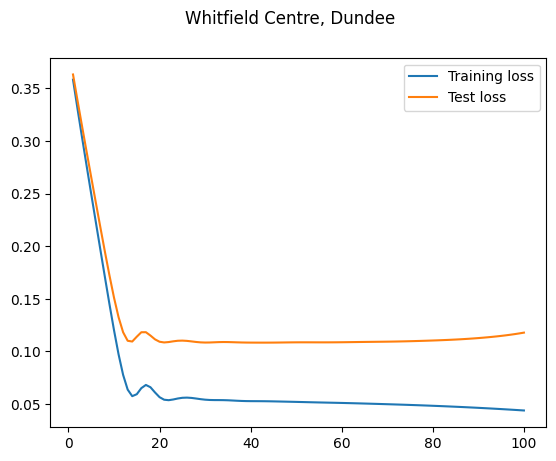

Whitfield Centre, Dundee Root Mean Squared Error (RMSE): 69.71146954237459

 Housing Office East, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0271, Test Loss: 0.1389
Epoch [20/100] - Training Loss: 0.0261, Test Loss: 0.1633


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0259, Test Loss: 0.1633
Epoch [40/100] - Training Loss: 0.0258, Test Loss: 0.1663
Epoch [50/100] - Training Loss: 0.0256, Test Loss: 0.1728
Epoch [60/100] - Training Loss: 0.0254, Test Loss: 0.1793
Epoch [70/100] - Training Loss: 0.0249, Test Loss: 0.1859
Epoch [80/100] - Training Loss: 0.0237, Test Loss: 0.1880
Epoch [90/100] - Training Loss: 0.0221, Test Loss: 0.1789
Epoch [100/100] - Training Loss: 0.0218, Test Loss: 0.1918


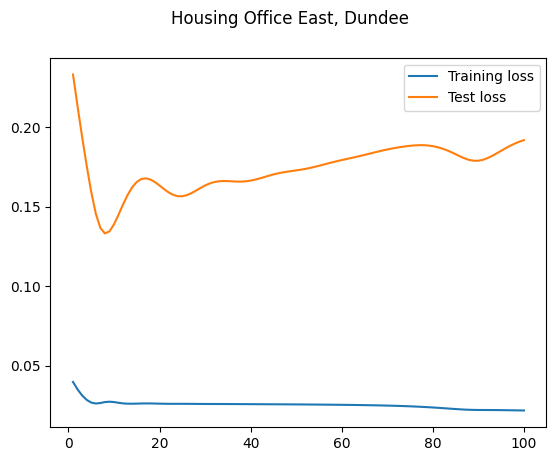

Housing Office East, Dundee Root Mean Squared Error (RMSE): 103.04396661420463

 Gellatly Street Car Park, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0609, Test Loss: 0.0349
Epoch [20/100] - Training Loss: 0.0410, Test Loss: 0.0506


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0414, Test Loss: 0.0445
Epoch [40/100] - Training Loss: 0.0407, Test Loss: 0.0472
Epoch [50/100] - Training Loss: 0.0406, Test Loss: 0.0458
Epoch [60/100] - Training Loss: 0.0404, Test Loss: 0.0460
Epoch [70/100] - Training Loss: 0.0403, Test Loss: 0.0456
Epoch [80/100] - Training Loss: 0.0402, Test Loss: 0.0453
Epoch [90/100] - Training Loss: 0.0400, Test Loss: 0.0451
Epoch [100/100] - Training Loss: 0.0399, Test Loss: 0.0448


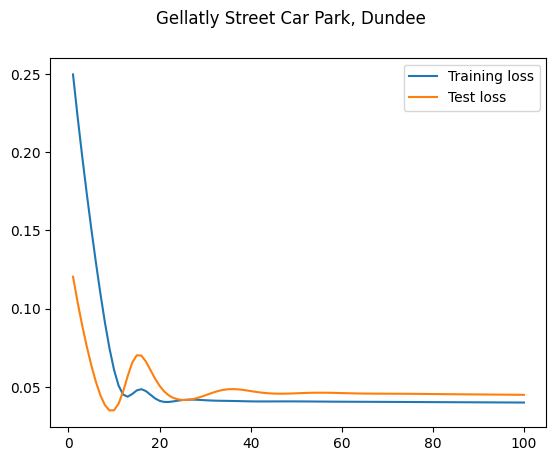

Gellatly Street Car Park, Dundee Root Mean Squared Error (RMSE): 90.1535525833268

 Public Works Dept, Clepington Rd. Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0567, Test Loss: 0.0245
Epoch [20/100] - Training Loss: 0.0353, Test Loss: 0.0678


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0263, Test Loss: 0.0368
Epoch [40/100] - Training Loss: 0.0175, Test Loss: 0.0279
Epoch [50/100] - Training Loss: 0.0077, Test Loss: 0.0102
Epoch [60/100] - Training Loss: 0.0023, Test Loss: 0.0013
Epoch [70/100] - Training Loss: 0.0022, Test Loss: 0.0011
Epoch [80/100] - Training Loss: 0.0021, Test Loss: 0.0013
Epoch [90/100] - Training Loss: 0.0021, Test Loss: 0.0012
Epoch [100/100] - Training Loss: 0.0020, Test Loss: 0.0012


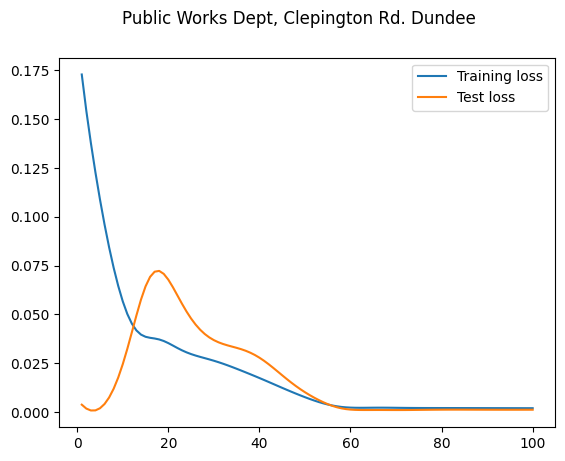

Public Works Dept, Clepington Rd. Dundee Root Mean Squared Error (RMSE): 57.59562966324401

 Marchbanks, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.1508, Test Loss: 0.0849
Epoch [20/100] - Training Loss: 0.0223, Test Loss: 0.0170


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0175, Test Loss: 0.0128
Epoch [40/100] - Training Loss: 0.0174, Test Loss: 0.0114
Epoch [50/100] - Training Loss: 0.0173, Test Loss: 0.0128
Epoch [60/100] - Training Loss: 0.0173, Test Loss: 0.0125
Epoch [70/100] - Training Loss: 0.0172, Test Loss: 0.0124
Epoch [80/100] - Training Loss: 0.0172, Test Loss: 0.0124
Epoch [90/100] - Training Loss: 0.0172, Test Loss: 0.0124
Epoch [100/100] - Training Loss: 0.0172, Test Loss: 0.0124


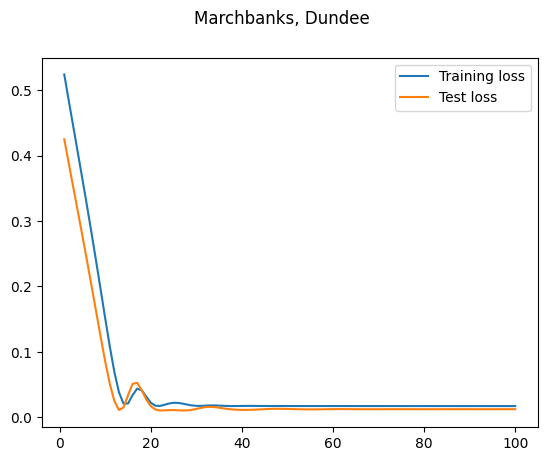

Marchbanks, Dundee Root Mean Squared Error (RMSE): 32.00154029271092

 Olympia Multi-Storey Car Park, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.1482, Test Loss: 0.0218
Epoch [20/100] - Training Loss: 0.0608, Test Loss: 0.1230


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0529, Test Loss: 0.0705
Epoch [40/100] - Training Loss: 0.0512, Test Loss: 0.0892
Epoch [50/100] - Training Loss: 0.0508, Test Loss: 0.0838
Epoch [60/100] - Training Loss: 0.0503, Test Loss: 0.0873
Epoch [70/100] - Training Loss: 0.0498, Test Loss: 0.0880
Epoch [80/100] - Training Loss: 0.0493, Test Loss: 0.0898
Epoch [90/100] - Training Loss: 0.0487, Test Loss: 0.0917
Epoch [100/100] - Training Loss: 0.0480, Test Loss: 0.0939


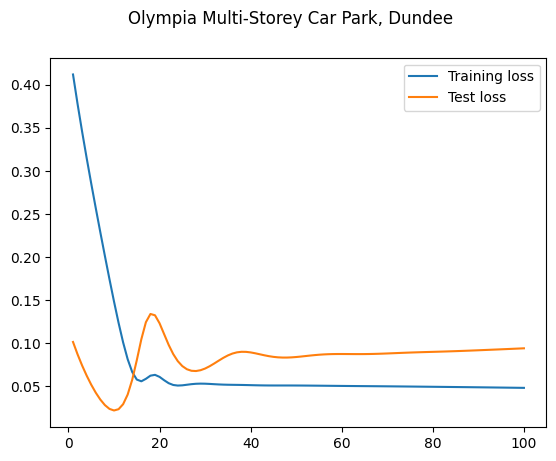

Olympia Multi-Storey Car Park, Dundee Root Mean Squared Error (RMSE): 100.34846531547363

 South Tay Street 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.1332, Test Loss: 0.1481
Epoch [20/100] - Training Loss: 0.0440, Test Loss: 0.0464


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0342, Test Loss: 0.0473
Epoch [40/100] - Training Loss: 0.0330, Test Loss: 0.0448
Epoch [50/100] - Training Loss: 0.0328, Test Loss: 0.0447
Epoch [60/100] - Training Loss: 0.0326, Test Loss: 0.0450
Epoch [70/100] - Training Loss: 0.0324, Test Loss: 0.0449
Epoch [80/100] - Training Loss: 0.0321, Test Loss: 0.0449
Epoch [90/100] - Training Loss: 0.0319, Test Loss: 0.0449
Epoch [100/100] - Training Loss: 0.0316, Test Loss: 0.0449


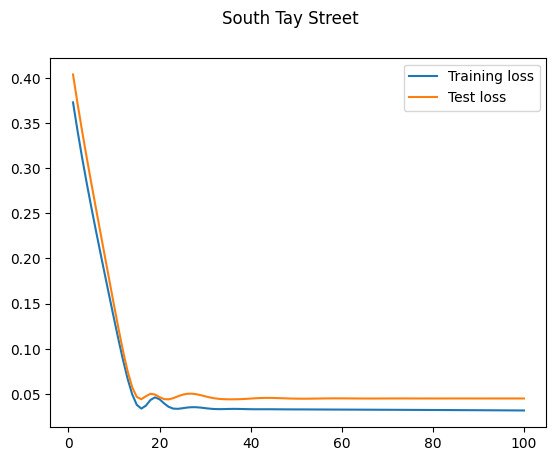

South Tay Street Root Mean Squared Error (RMSE): 52.120264402858005

 Ardler Complex, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0752, Test Loss: 0.0227
Epoch [20/100] - Training Loss: 0.0587, Test Loss: 0.0453


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0571, Test Loss: 0.0335
Epoch [40/100] - Training Loss: 0.0553, Test Loss: 0.0367
Epoch [50/100] - Training Loss: 0.0540, Test Loss: 0.0338
Epoch [60/100] - Training Loss: 0.0526, Test Loss: 0.0329
Epoch [70/100] - Training Loss: 0.0512, Test Loss: 0.0310
Epoch [80/100] - Training Loss: 0.0500, Test Loss: 0.0292
Epoch [90/100] - Training Loss: 0.0490, Test Loss: 0.0275
Epoch [100/100] - Training Loss: 0.0483, Test Loss: 0.0266


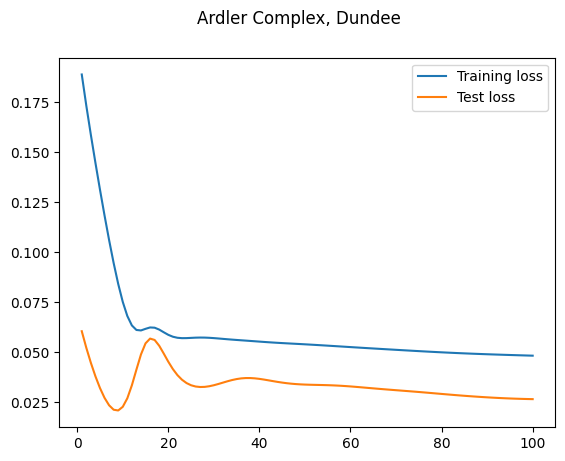

Ardler Complex, Dundee Root Mean Squared Error (RMSE): 18.660435266255348

 Menziehill House, Dundee 

(23, 5, 1) (23, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0608, Test Loss: 0.0192
Epoch [20/100] - Training Loss: 0.0595, Test Loss: 0.0186


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0590, Test Loss: 0.0177
Epoch [40/100] - Training Loss: 0.0582, Test Loss: 0.0182
Epoch [50/100] - Training Loss: 0.0574, Test Loss: 0.0180
Epoch [60/100] - Training Loss: 0.0566, Test Loss: 0.0180
Epoch [70/100] - Training Loss: 0.0556, Test Loss: 0.0180
Epoch [80/100] - Training Loss: 0.0545, Test Loss: 0.0180
Epoch [90/100] - Training Loss: 0.0532, Test Loss: 0.0181
Epoch [100/100] - Training Loss: 0.0516, Test Loss: 0.0182


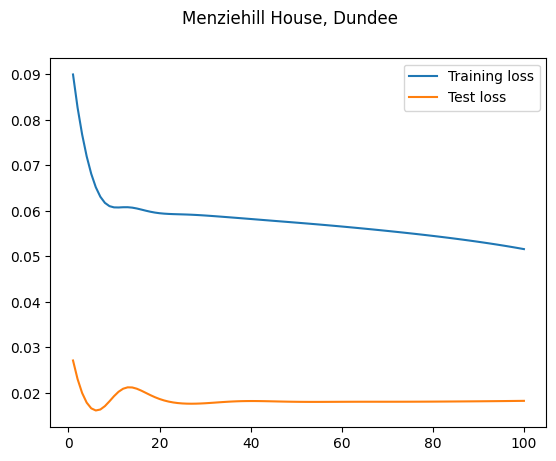

Menziehill House, Dundee Root Mean Squared Error (RMSE): 26.00465380675494

 Turriff House Rannoch Road, Dundee 

(21, 5, 1) (21, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.0513, Test Loss: 0.0092
Epoch [20/100] - Training Loss: 0.0477, Test Loss: 0.0082


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100] - Training Loss: 0.0469, Test Loss: 0.0078
Epoch [40/100] - Training Loss: 0.0453, Test Loss: 0.0080
Epoch [50/100] - Training Loss: 0.0440, Test Loss: 0.0074
Epoch [60/100] - Training Loss: 0.0428, Test Loss: 0.0070
Epoch [70/100] - Training Loss: 0.0417, Test Loss: 0.0066
Epoch [80/100] - Training Loss: 0.0407, Test Loss: 0.0063
Epoch [90/100] - Training Loss: 0.0398, Test Loss: 0.0061
Epoch [100/100] - Training Loss: 0.0389, Test Loss: 0.0060


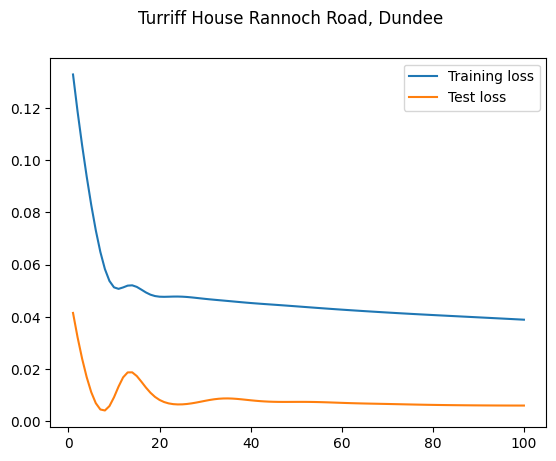

Turriff House Rannoch Road, Dundee Root Mean Squared Error (RMSE): 13.163556512540932

 Trades Lane 

(14, 5, 1) (14, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.3117, Test Loss: 0.0367
Epoch [20/100] - Training Loss: 0.1508, Test Loss: 0.0183
Epoch [30/100] - Training Loss: 0.0648, Test Loss: 0.1095
Epoch [40/100] - Training Loss: 0.0683, Test Loss: 0.1023


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [50/100] - Training Loss: 0.0664, Test Loss: 0.0614
Epoch [60/100] - Training Loss: 0.0638, Test Loss: 0.0767
Epoch [70/100] - Training Loss: 0.0640, Test Loss: 0.0873
Epoch [80/100] - Training Loss: 0.0634, Test Loss: 0.0748
Epoch [90/100] - Training Loss: 0.0633, Test Loss: 0.0744
Epoch [100/100] - Training Loss: 0.0632, Test Loss: 0.0758


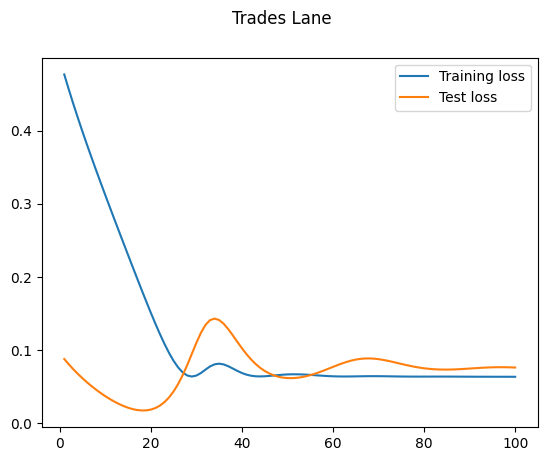

Trades Lane Root Mean Squared Error (RMSE): 46.04671691958115

 University of Dundee, Nethergate, Dundee 

(14, 5, 1) (14, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.2251, Test Loss: 0.0434
Epoch [20/100] - Training Loss: 0.1161, Test Loss: 0.0396
Epoch [30/100] - Training Loss: 0.0942, Test Loss: 0.1140
Epoch [40/100] - Training Loss: 0.0865, Test Loss: 0.0793


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [50/100] - Training Loss: 0.0874, Test Loss: 0.0645
Epoch [60/100] - Training Loss: 0.0855, Test Loss: 0.0782
Epoch [70/100] - Training Loss: 0.0855, Test Loss: 0.0832
Epoch [80/100] - Training Loss: 0.0850, Test Loss: 0.0767
Epoch [90/100] - Training Loss: 0.0847, Test Loss: 0.0785
Epoch [100/100] - Training Loss: 0.0843, Test Loss: 0.0809


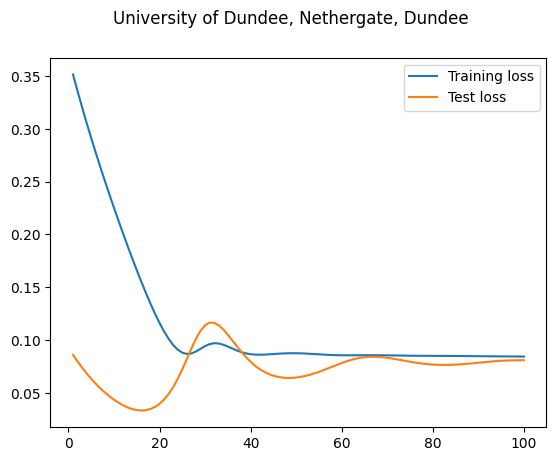

University of Dundee, Nethergate, Dundee Root Mean Squared Error (RMSE): 36.73252520653497

 Janet Brougham House, Dundee 

(1, 5, 1) (1, 1) (12, 5, 1) (12, 1)
Epoch [10/100] - Training Loss: 0.1900, Test Loss: 0.1234
Epoch [20/100] - Training Loss: 0.0476, Test Loss: 0.0627
Epoch [30/100] - Training Loss: 0.0132, Test Loss: 0.1319
Epoch [40/100] - Training Loss: 0.0000, Test Loss: 0.0813


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [50/100] - Training Loss: 0.0026, Test Loss: 0.0727
Epoch [60/100] - Training Loss: 0.0001, Test Loss: 0.0876
Epoch [70/100] - Training Loss: 0.0002, Test Loss: 0.0866
Epoch [80/100] - Training Loss: 0.0001, Test Loss: 0.0810
Epoch [90/100] - Training Loss: 0.0000, Test Loss: 0.0844
Epoch [100/100] - Training Loss: 0.0000, Test Loss: 0.0844


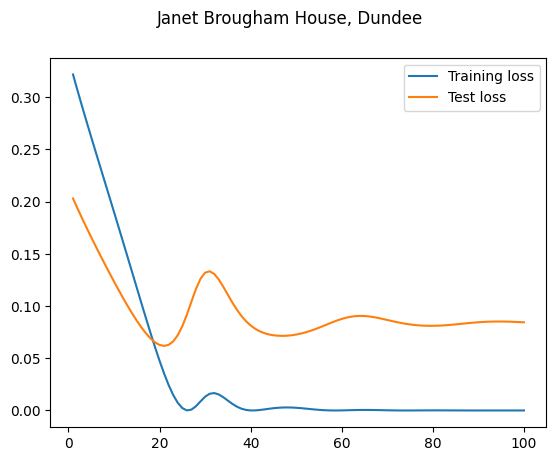

Janet Brougham House, Dundee Root Mean Squared Error (RMSE): 45.22923074194709


In [57]:
stations_dict_temp = stations_dict.copy()
stations_dict_temp.pop('DCC Environment, 34 Harefield Road', None)
stations_dict_temp.pop('Sinclair Street', None)
stations_dict_temp.pop('Earn Cresent, Dundee', None)

stations_temp = list(stations.copy())
stations_temp.remove('DCC Environment, 34 Harefield Road')
stations_temp.remove('Sinclair Street')
stations_temp.remove('Earn Cresent, Dundee')

train_lstm(df_dict=stations_dict_temp, type='weekly', sequence_length=5, stations=stations_temp, 
           num_epochs=100, predictions_dict=weekly_predictions_dict, test_obs=12)

In [58]:
weekly_predictions_dict.pop('DCC Environment, 34 Harefield Road', None)
weekly_predictions_dict.pop('Sinclair Street', None)
weekly_predictions_dict.pop('Earn Cresent, Dundee', None)

{'y_test': [], 'y_pred': [], 'rmse': 0}

In [59]:
# File path to save the dictionary
file_path = 'weekly_predictions_dundee.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(weekly_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'weekly_predictions_dundee.pkl'


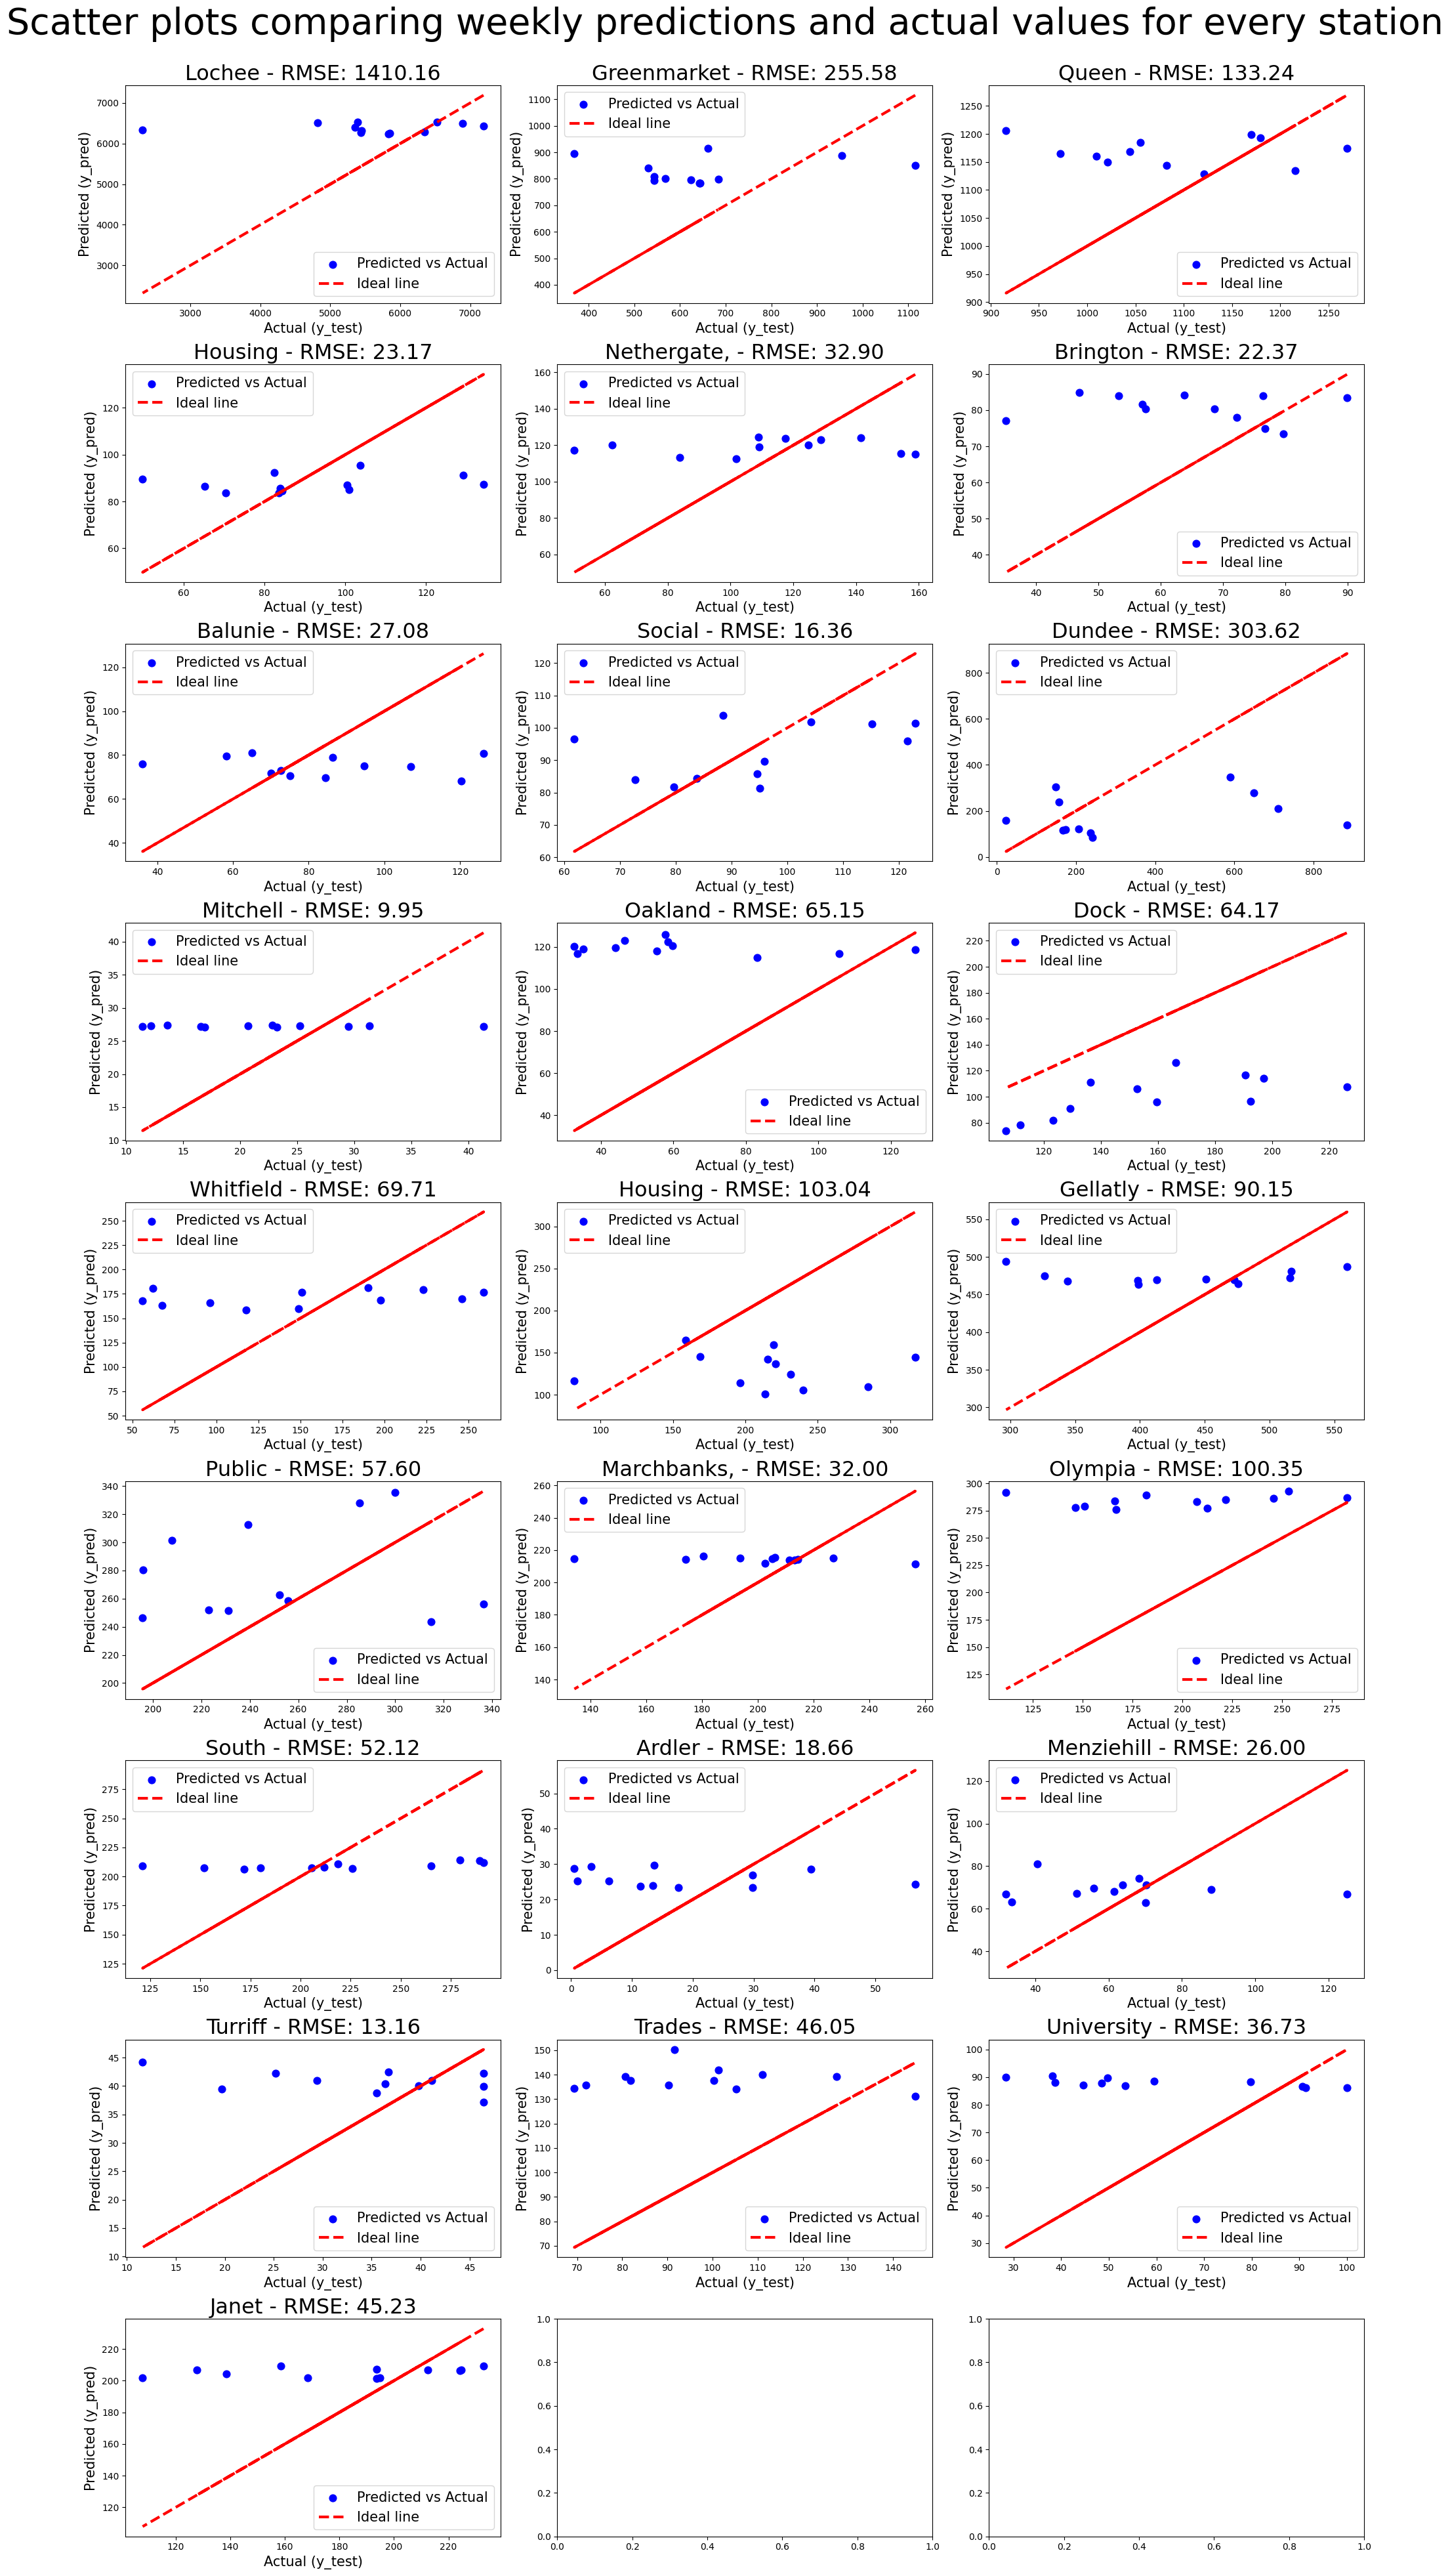

In [62]:
# Define the number of rows and columns for subplots
n_rows = 9
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 40))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(weekly_predictions_dict.keys()):
    # Get data for the current station
    station_data = weekly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', s=60)
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line', linewidth=3)

    axs[i].set_title(f'{station.split()[0]} - RMSE: {rmse:.2f}', fontsize=23)
    axs[i].set_xlabel('Actual (y_test)', fontsize=15)
    axs[i].set_ylabel('Predicted (y_pred)', fontsize=15)
    axs[i].legend(fontsize=15)

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Scatter plots comparing weekly predictions and actual values for every station', fontsize=40)
plt.show()

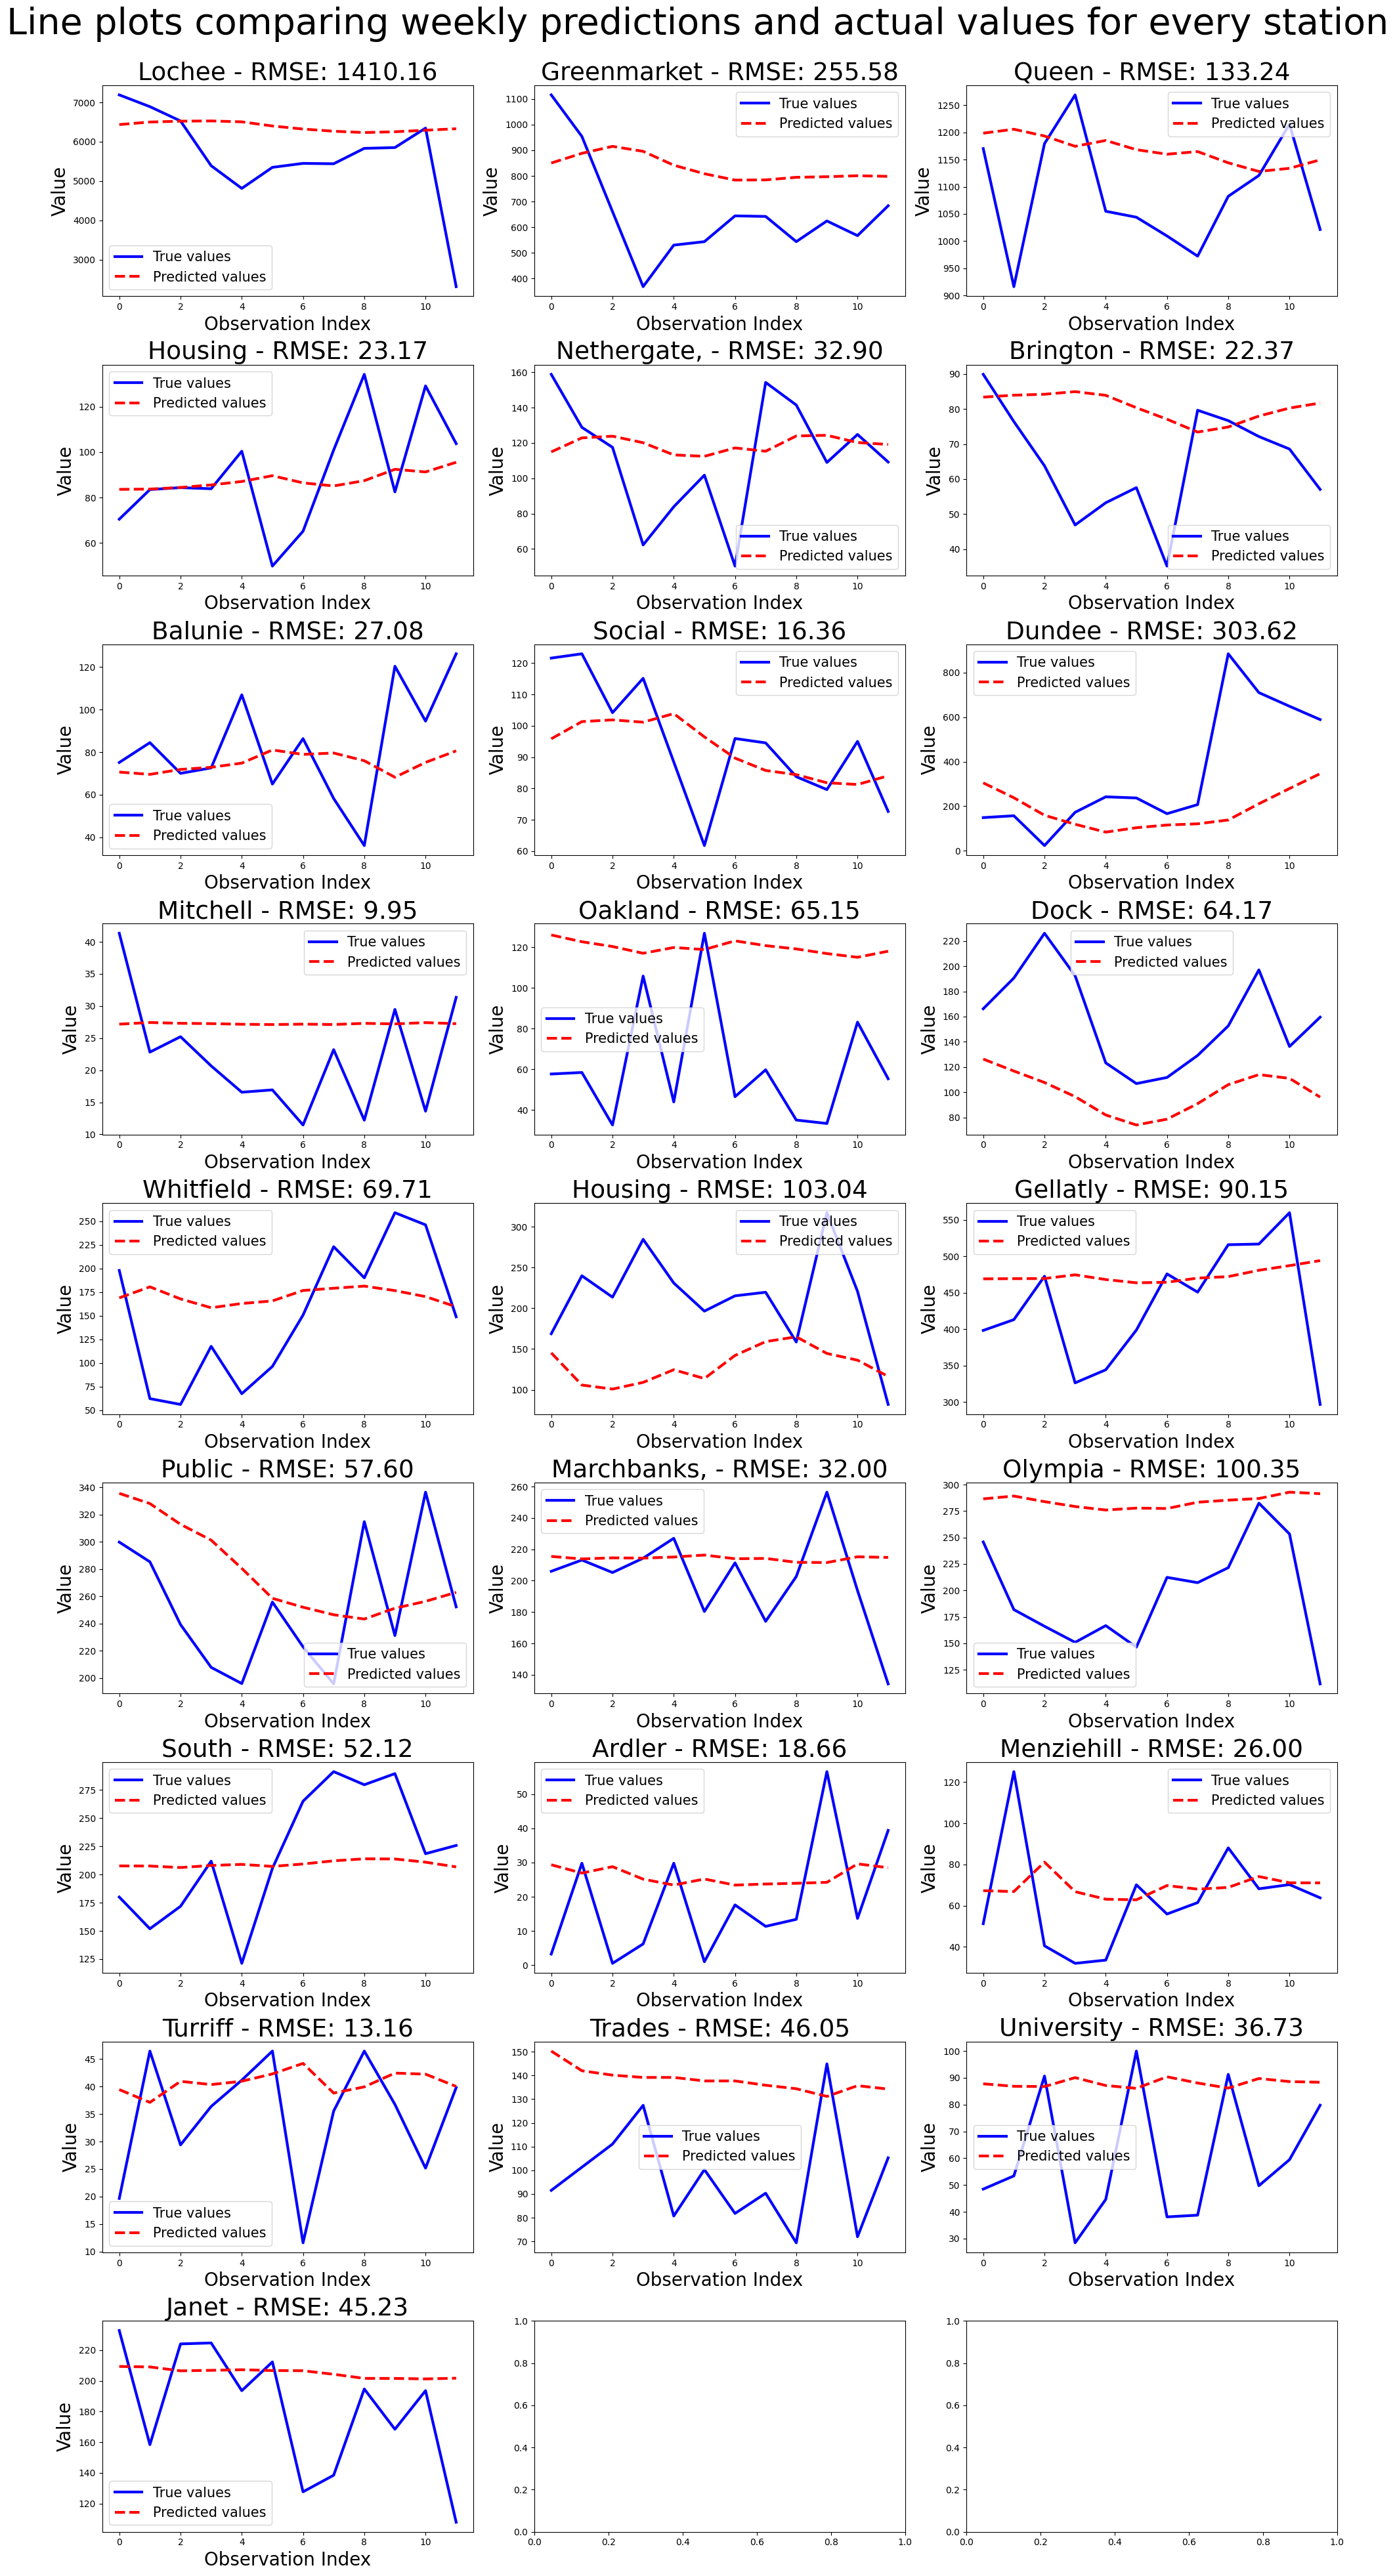

In [64]:
# Define the number of rows and columns for subplots
n_rows = 9
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 40))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(weekly_predictions_dict.keys()):
    # Get data for the current station
    station_data = weekly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values', linewidth=3)
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values', linewidth=3)

    axs[i].set_title(f'{station.split()[0]} - RMSE: {rmse:.2f}', fontsize=27)
    axs[i].set_xlabel('Observation Index', fontsize=20)
    axs[i].set_ylabel('Value', fontsize=20)
    axs[i].legend(fontsize=15)

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Line plots comparing weekly predictions and actual values for every station', fontsize=40)
plt.show()


Similarly to daily predictions, in case of weekly predictions suffer from the same previousely mentioned issues and the resulting forcast line is flat.

### Monthly predictions

Monthly predictions are not possible to train due to lack of suffieciently large timeframe of data. Here we have less than a year which does not allow us to create enough training observations.

### Transfer learning

After comparing the performance of LSTM models trained for 3 different cities it is clear that the Palo Alto models perform best. Perth and Dundee both suffer from data quality issues. This borught the idea of resorting to transfer learning. The following sections evaluates weekly predictions obtained through locally trained model (on Dundee dataset) versus predictions from the model trained in Palo Alto and evaluated in Dundee. The transfered model was trained on Palo Alto MPL station data.

The following function is runs pieces of train_model function necessary to process the data. Training part has been excluded as it is no longer needed.

In [83]:
def process_data(df_dict, type, sequence_length, stations, predictions_dict, test_obs):
    for station in stations:
        temp_df = df_dict[station][type]['Total kWh']

        # Scaling dataset
        reshaped_data = np.reshape(temp_df, (-1,1))
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(reshaped_data)

        # Create sequences and labels for training data
        sequence_length = sequence_length  # Number of time steps to look back
        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:i+sequence_length])
            y.append(scaled_data[i+sequence_length])
        X, y = np.array(X), np.array(y)

        # Splitting the dataset
        X_test = X[-test_obs:]
        y_test = y[-test_obs:]
    
        # Convert data to PyTorch tensors
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32)

        predictions_dict[station]['X_test'] = X_test        
        predictions_dict[station]['y_test'] = y_test 
        predictions_dict[station]['scaler'] = scaler      

In [84]:
# Initialize dict for storing predictions
weekly_predictions_dict_transfer = {}
for station in stations:
    weekly_predictions_dict_transfer[station] = {'scaler': None, 'X_test': [], 'y_test':[], 'y_pred':[], 'rmse':0}

weekly_predictions_dict_transfer.pop('DCC Environment, 34 Harefield Road', None)
weekly_predictions_dict_transfer.pop('Sinclair Street', None)
weekly_predictions_dict_transfer.pop('Earn Cresent, Dundee', None)
weekly_predictions_dict_transfer.pop('Lochee Charging Hub, Dundee', None)
weekly_predictions_dict_transfer.pop('University of Dundee, Nethergate, Dundee', None)
weekly_predictions_dict_transfer.pop('Janet Brougham House, Dundee', None)
weekly_predictions_dict_transfer.pop('Trades Lane', None)

{'scaler': None, 'X_test': [], 'y_test': [], 'y_pred': [], 'rmse': 0}

In [85]:
stations_dict_temp = stations_dict.copy()
stations_dict_temp.pop('DCC Environment, 34 Harefield Road', None)
stations_dict_temp.pop('Sinclair Street', None)
stations_dict_temp.pop('Earn Cresent, Dundee', None)
stations_dict_temp.pop('Lochee Charging Hub, Dundee', None)
stations_dict_temp.pop('University of Dundee, Nethergate, Dundee', None)
stations_dict_temp.pop('Janet Brougham House, Dundee', None)
stations_dict_temp.pop('Trades Lane', None)

stations_temp = list(stations.copy())
stations_temp.remove('DCC Environment, 34 Harefield Road')
stations_temp.remove('Sinclair Street')
stations_temp.remove('Earn Cresent, Dundee')
stations_temp.remove('Lochee Charging Hub, Dundee')
stations_temp.remove('University of Dundee, Nethergate, Dundee')
stations_temp.remove('Janet Brougham House, Dundee')
stations_temp.remove('Trades Lane')

In [86]:
process_data(df_dict=stations_dict_temp, type='weekly', sequence_length=30, stations=stations_temp, 
             predictions_dict=weekly_predictions_dict_transfer, test_obs=12)

In [87]:
predictions_dict = weekly_predictions_dict_transfer

for station in stations_temp:
    scaler = weekly_predictions_dict_transfer[station]['scaler']

    input_size = 1
    num_layers = 1
    hidden_size = 64
            
    # Reinitalize the model class
    model = LSTMModel(input_size, hidden_size, num_layers).to(device)

    # Load model
    model.load_state_dict(torch.load("lstm_model_weekly_MPL.pth"))
    model.eval()  # Set the model to evaluation mode

    # Move input tensor to the same device as model's parameters
    X_test = weekly_predictions_dict_transfer[station]['X_test'].to(device)
    y_test = weekly_predictions_dict_transfer[station]['y_test']

    # Pass the entire test set through the model to obtain predictions
    with torch.no_grad():
        # Obtain predictions for the entire test set
        predictions_test = model(X_test)
        
        # Convert predictions from tensors to NumPy arrays
        predictions_test = predictions_test.cpu().numpy()

    # Reverse predictions
    y_test_reversed = scaler.inverse_transform(y_test.reshape(-1, 1))
    predictions_reversed = scaler.inverse_transform(predictions_test.reshape(-1, 1))

    # Save y_test and predictions
    predictions_dict[station]['y_pred'] = predictions_reversed
    predictions_dict[station]['y_test'] = y_test_reversed

    # Calculate mean squared error
    mse = mean_squared_error(y_test_reversed, predictions_reversed)

    # Calculate root mean squared error
    rmse = np.sqrt(mse)

    print(f"{station} Root Mean Squared Error (RMSE):", rmse)
    predictions_dict[station]['rmse'] = rmse

c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\bald

Greenmarket Multi Car Park, Dundee Root Mean Squared Error (RMSE): 180.28937555401123
Queen Street Car Park, Broughty Ferry, Dundee Root Mean Squared Error (RMSE): 109.51037015058755
Housing Office West, Dundee Root Mean Squared Error (RMSE): 28.21207088394768
Nethergate, Dundee Root Mean Squared Error (RMSE): 38.084885651980336
Brington Place Sheltered Housing, Dundee Root Mean Squared Error (RMSE): 16.83455976046998
Balunie Drive, Dundee Root Mean Squared Error (RMSE): 30.21763366880114
Social Work Building, Jack Martin Way, Dundee Root Mean Squared Error (RMSE): 20.802249559672287
Dundee Ice Arena, Dundee Root Mean Squared Error (RMSE): 229.6177991041813
Mitchell Street, Dundee Root Mean Squared Error (RMSE): 8.443729630277652
Oakland Day Centre, Dundee Root Mean Squared Error (RMSE): 38.02191604131285
Dock Street, Dundee Root Mean Squared Error (RMSE): 46.27902640824371
Whitfield Centre, Dundee Root Mean Squared Error (RMSE): 60.70383889187623
Housing Office East, Dundee Root Mean 

c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [99]:
stations_to_compare = ['Greenmarket Multi Car Park, Dundee', 'Oakland Day Centre, Dundee', 
                       'Olympia Multi-Storey Car Park, Dundee', 'Housing Office East, Dundee',
                       'Dock Street, Dundee']

all_stations = set(weekly_predictions_dict.keys())

transfer_dict = weekly_predictions_dict_transfer.copy()
local_predictions_dict = weekly_predictions_dict.copy()
for station in all_stations:
    if station not in stations_to_compare:
        transfer_dict.pop(station, None)
        local_predictions_dict.pop(station, None)

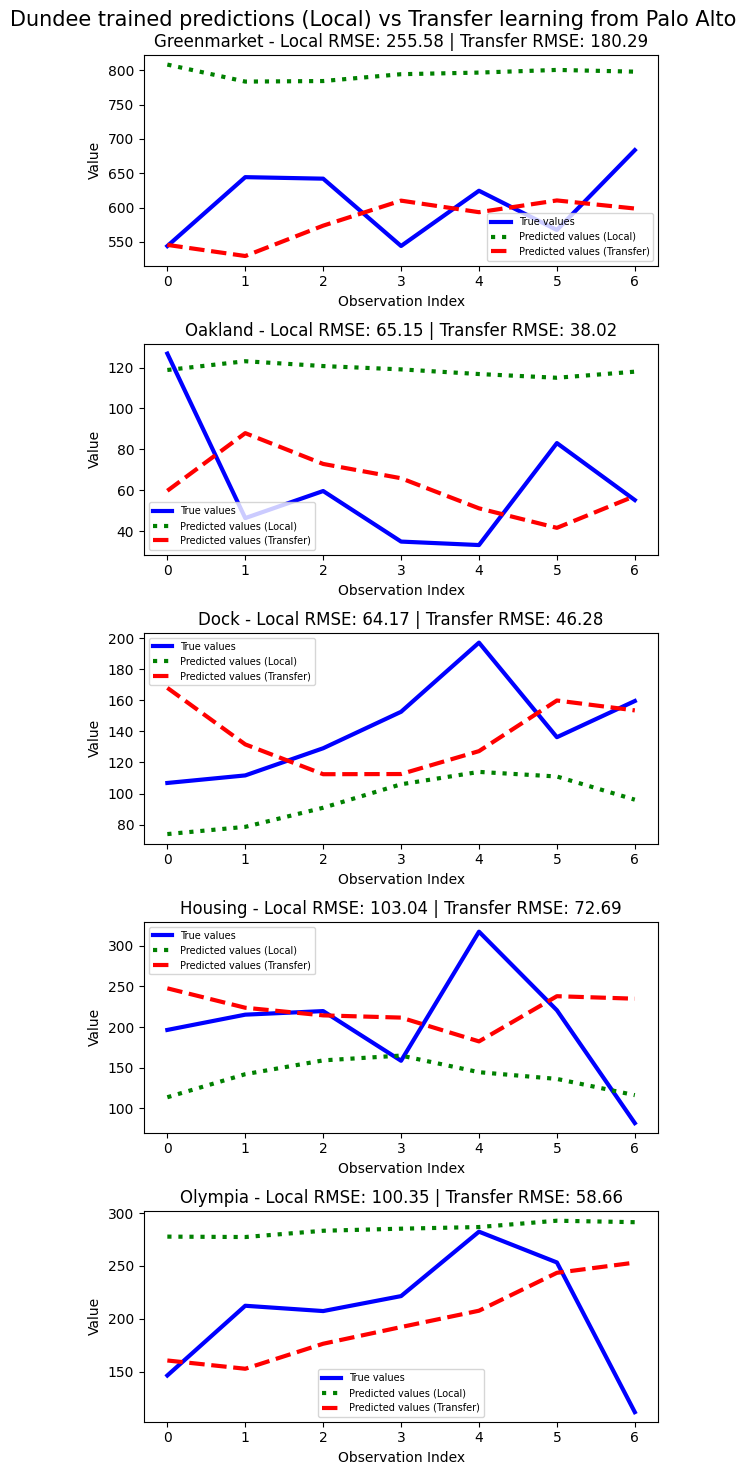

In [123]:
# Define the number of rows for subplots
n_rows = len(transfer_dict)

# Create subplots
fig, axs = plt.subplots(n_rows, 1, figsize=(6, 15))

# Iterate over each station
for i, station in enumerate(transfer_dict.keys()):

    # Get transfer predictions
    transfer_data = transfer_dict[station]
    y_test = transfer_data['y_test'][-7:]
    transfer_y_pred = transfer_data['y_pred'][-7:]
    transfer_rmse = transfer_data['rmse']

    # Get locally trained predictions
    local_data = local_predictions_dict[station]
    local_y_pred = local_data['y_pred'][-7:]
    local_rmse = local_data['rmse']

    # Plot true values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values', linewidth=3)

    # Plot local predictions
    axs[i].plot(x, local_y_pred, color='green', linestyle=':', label='Predicted values (Local)', linewidth=3)

    # Plot transfer predictions
    axs[i].plot(x, transfer_y_pred, color='red', linestyle='--', label='Predicted values (Transfer)', linewidth=3)

    # Set title, labels, and legend for each subplot
    axs[i].set_title(f'{station.split()[0]} - Local RMSE: {local_rmse:.2f} | Transfer RMSE: {transfer_rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend(fontsize=7)

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Dundee trained predictions (Local) vs Transfer learning from Palo Alto', fontsize=15)
plt.show()


Five Dundee stations where chosen to ilustrate the transfer learning results. In case of all those stations the transfered model outperforms the locally trained one. Forecasts obtained from the Palo Alto trained model follow the pattern of the data much better and are not flat like those from locally trained model. This has a great business implications. It means that behaviour between the stations, and between the cities, is similar enough to justify using model trained on different data. A company wanting to expand its operations by setting up a new station or starting to operate in an entirely different country can resort to transfer learning apporach and use already deployed models. This means that its not necessary for a company to wait until sufficiently large timeseries of charging records is gathered to produce decent forecasts. It also can save a lot of costs and time associated with model development.

### Conclusions

All in all due to not sufficiently large timeframe of data the LSTM model failed to produce satisfactory forecasts. The issue encountered here most certainly reflects the reality in which companies starting new operation elsewhere have to run the business long enough to gather data necessary to train the model. This can be bypassed by transfer learning approach. If a company has an operation running long enough in one area it can simply use the model trained there to obtain predictions for its operations elsewhere. This approach helps cut costs associated with developing the model and helps start forcasting faster giving an upperhand in planning.